# **Лучшая FFN**
*Домашнее задание №1 по курсу "Прикладная алгебра"*

---

Выполнил студент 317 группы Зиннуров А.Р.

### **Датасет**

**Sklearn-toy** - 7 небольших стандартных наборов данных, которые поставляются вместе с библиотекой машинного обучения **scikit-learn** и поэтому не требуют дополнительной загрузки. Используются как мини-аналог реальных данных для первичного исследования поведения алгоритмов. В их число входят следующие датасеты:
* *Boston house prices dataset (regression)*
* *Iris plants dataset (classification)*
* *Diabetes dataset (regression)*
* *Optical recognition of handwritten digits dataset (classification)*
* *Linnerrud dataset (multi regression)*
* *Wine recognition dataset (classification)*
* *Breast cancer wisconsin (diagnostic) dataset (classification)*

### **Тип сети**

**FFN (Feedforward Neural Network, Сеть прямого распространения)** - это искусственная нейронная сеть, в которой соединения между узлами не образуют цикл. Была первым и самым простым типом искусственной нейронной сети. В этой сети информация перемещается только в одном направлении вперёд от входных узлов, через скрытые узлы (если они есть) и к выходным узлам.

<center><img src=https://i.ytimg.com/vi/efaDKT4_IKY/maxresdefault.jpg alt="image" width="600"/></center>


### **От чего зависит?**

1. **Глубина** - количество слоёв в нейронной сети.

2. **Ширина** - количество нейронов в одном слое нейронной сети.

3. **Batch Normalization (BN)** - метод, который позволяет повысить производительность и стабилизировать работу искусственных нейронных сетей. Суть данного метода заключается в том, что некоторым слоям нейронной сети на вход подаются данные, предварительно отмасштабированные выученным способом.

4. **Dropout (DO)** - метод регуляризации в нейронных сетях, при котором случайным образом исключается часть нейронов в процессе обучения.

    Рассматриваемые доли исключённых нейронов:
    * 0%
    * 25%
    * 50%
    * 75%

5. **Init** - способ инициализации весов в нейронной сети.

    Рассматриваемые методы инициализации:
    * инициализация по умолчанию;
    * инициализация одними единицами;
    * инициализация одними нулями;
    * инициализация ;
    * инициализация ;

6. **Активация** - выбор нелинейной функции активации в нейронной сети.

    Рассматриваемые функции активации:
    * *Sigmoid* - Сигмоидная функция активации;
    * *Tanh* - Гиперболический тангенс;
    * *ReLU* - Rectified Linear Unit;
    * *LeakyReLU* - Leaky Rectified Linear Unit;
    * *ELU* - Exponential Linear Unit;
    * *SELU* - Scaled Exponential Linear Unit;

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

from sklearn import datasets
from sklearn.model_selection import train_test_split

import warnings
import numpy as np
from IPython import display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


### Реализация нейросети

In [ ]:
class FFN(nn.Module):

    def __init__(self, num_layers, input_dim, hidden_dim, output_dim,
                 batch_norm, dropout, init, act):
        """
        Класс, реализующий FFN.

        Нейросеть состоит из подряд идущих блоков со структурой:
        
        FC -> Dropout -> BatchNorm -> Activation

        Количество блоков определяет параметр глубины. Каждый блок имеет линейную часть
        одинаковой ширины, которая задаётся, и обучаемый bais. Имеется возможность не
        включать в блок BatchNorm и Dropout. Имеется возможность задать функцию
        активации и способ инициализации.

        Args:
            num_layers: int - число слоёв;
            input_dim: int - число нейронов во входном слое;
            hidden_dim: int - число нейронов в скрытом слое;
            output_dim: int - число нейронов в выходном слое;
            batch_norm: bool - применять ли батч-нормализацию;
            dropout: float in [0, 1] - вероятность удаления нейрона в dropout;
            init: nn.init... - способ инициализации;
            act: nn.Module - функция активации;
        """
        super(FFN, self).__init__()
        layers = []
        in_channels = input_dim
        if num_layers > 1:
            out_channels = hidden_dim
        else:
            out_channels = output_dim
        for i in range(num_layers):
            linear = nn.Linear(in_channels, out_channels)
            if init:
                if (act == nn.ReLU) and ((init == nn.init.kaiming_uniform_) or
                                         (init == nn.init.kaiming_normal_)):
                    init(linear.weight, nonlinearity="relu")
                else:
                    init(linear.weight)
                linear.bias.data.fill_(0.01)
            layers.append(linear)
            if dropout:
                layers.append(nn.Dropout(dropout))
            if batch_norm:
                layers.append(nn.BatchNorm1d(out_channels))
            in_channels = out_channels
            if i == num_layers - 2:
                out_channels = output_dim
            else:
                out_channels = hidden_dim
            layers.append(act())
        self.ffn = nn.Sequential(*layers)

    def forward(self, x):
        res = self.ffn(x)
        return res

### Реализация функций обучения и тестирования

In [ ]:
def val(epoch, model, criterion, val_dataloader, device="cpu",
        print_flag=False, clf_flag=False):
    """
    Функция оценки качества.

    Args:
        epoch: int - номер эпохи;
        model: nn.Module - сеть;
        criterion: критерий качества;
        val_dataloader: загрузчик данных, на которых проверяется качество;
        device: str - используемый девайс;
        print_flag: bool - печатать ли качество;
        clf_flag: bool - решается ли задача классификации;
    """
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        n = 0
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            if clf_flag:
                labels.squeeze_()
            loss = criterion(outputs, labels)
            total_loss += loss.cpu().item()
            n += len(labels)
            if clf_flag:
                _, predicted = torch.max(outputs, 1)
                total_acc += (labels == predicted).sum().cpu()
            
    loss_epoch = total_loss / n
    if clf_flag:
        acc_epoch = total_acc / n
    if print_flag:
        if clf_flag:
            print(f"[EPOCH]: {epoch}, [LOSS]: {loss_epoch:.4f}, [ACCURACY]: {acc_epoch:.4f}")
        else:
            print(f"[EPOCH]: {epoch}, [LOSS]: {loss_epoch:.4f}")
    if clf_flag:
        return acc_epoch
    else:
        return loss_epoch

In [ ]:
def train(model, num_epoch, criterion, optimizer, train_dataloader,
          val_dataloader, device="cpu", scheduler=None, clf_flag=False):
    """
    Функция обучения.

    Args:
        model: nn.Module - сеть;
        num_epoch: int - число эпох;
        criterion: критерий качества;
        optimizer: оптимизатор;
        train_dataloader: загрузчик обучающих данных;
        val_dataloader: загрузчик валидационных данных;
        device: str - используемый девайс;
        scheduler: программатор;
        clf_flag: bool - решается ли задача классификации;
    """
    model = model.to(device)
    model.train()
    loss_list_val = []
    loss_list_train = []
    for epoch in tqdm(range(1, num_epoch + 1)):
        for inputs, labels in train_dataloader:
            optimizer.zero_grad(set_to_none=True)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            if clf_flag:
                labels.squeeze_()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        if epoch % 10 == 0:
            loss_list_val.append(val(epoch, model, criterion, val_dataloader,
                                     device, clf_flag=clf_flag))
            loss_list_train.append(val(epoch, model, criterion, train_dataloader,
                                       device, print_flag=True, clf_flag=clf_flag))
    return loss_list_val, loss_list_train

### Реализация датасета и функции загрузки датасетов из Sklearn-toy

In [ ]:
class ToyDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        sample = torch.from_numpy(self.X[idx])
        target = torch.from_numpy(np.array([self.y[idx]]))
        return sample, target
    
    def __len__(self):
        return self.X.shape[0]

In [ ]:
def load_dataset(dataset_name, batch_size):
    """
    Загружает датасет из Toy datasets, возвращает загрузчики данных.

    Args:
        dataset_name: str - название датасета;
        batch_size: int - размер батча;
    """
    if dataset_name == "boston":
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            X, y = datasets.load_boston(return_X_y=True)
            X = X.astype(np.float32)
            y = y.astype(np.float32)
    elif dataset_name == "iris":
        X, y = datasets.load_iris(return_X_y=True)
        X = X.astype(np.float32)
    elif dataset_name == "diabetes":
        X, y = datasets.load_diabetes(return_X_y=True)
        X = X.astype(np.float32)
        y = y.astype(np.float32)
    elif dataset_name == "digits":
        X, y = datasets.load_digits(return_X_y=True)
        X = X.astype(np.float32)
    elif dataset_name == "linnerud":
        X, y = datasets.load_linnerud(return_X_y=True)
        X = X.astype(np.float32)
        y = y.astype(np.float32)
    elif dataset_name == "wine":
        X, y = datasets.load_wine(return_X_y=True)
        X = X.astype(np.float32)
    elif dataset_name == "breast_cancer":
        X, y = datasets.load_breast_cancer(return_X_y=True)
        X = X.astype(np.float32)
    else:
        print("load_dataset: ERROR: Incorrect dataset name!")
        return None

    X_res, X_test, y_res, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
    X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.25, random_state=42)
    print(f"X.shape: {X.shape}, y.shape: {y.shape}")
    print("Train samples:", X_train.shape[0])
    print("Test samples:", X_test.shape[0])
    print("Val samples:", X_val.shape[0])

    train_dataset = ToyDataset(X_train, y_train)
    test_dataset = ToyDataset(X_test, y_test)
    val_dataset = ToyDataset(X_val, y_val)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader, val_dataloader

### Реализация функции печати графиков

In [ ]:
def print_graphic(num_epoch, loss_list_1, label_1, parametrs=None, loss_list_2=None,
                  label_2=None, ylim=None, figsize=(17, 9), clf_flag=False):
    """
    Функция печати графика.

    Args:
        num_epoch: int - кол-во эпох;
        loss_list_1: list(list) - список списков функций потерь для некоторых данных (например валидационных);
        label_1: str - метка легенды, соотв. loss_list_1;
        parametrs: list, optional - список изменяющихся параметров;
        loss_list_2: list(list), optional - список списков функций потерь для некоторых данных (например тренировочных);
        label_2: str - метка легенды, соотв. loss_list_2;
        ylim tuple(2): optional - границы оси y;
        figsize: tuple(2), optional - размер графика;
        clf_flag: bool, optional - решается ли задача классификации;
    """
    fig = plt.figure(figsize=figsize)

    if clf_flag:
        quality_name = "Accuracy"
    else:
        quality_name = "MSE"
    plt.title(f"Зависимость {quality_name} от номера эпохи", fontsize=17)    
    plt.xlabel("Номер эпохи", fontsize=14)
    plt.ylabel(quality_name, fontsize=14)

    colors = ['g', 'c', 'm', 'b', 'y', 'k', 'r', 'olive'] # 8
    for i in range(len(loss_list_1)):
        label = f"{label_1}"
        if parametrs is not None:
            if callable(parametrs[i]):
                label = label + f"={parametrs[i].__name__}"
            else:
                label = label + f"={parametrs[i]}"
        plt.plot(range(1, num_epoch + 1, 10), loss_list_1[i], linestyle="-", c=colors[i], label=label)

    if loss_list_2 is not None:
        for i in range(len(loss_list_2)):
            label = f"{label_2}"
            if parametrs is not None:
                if callable(parametrs[i]):
                    label = label + f"={parametrs[i].__name__}"
                else:
                    label = label + f"={parametrs[i]}"
            plt.plot(range(1, num_epoch + 1, 10), loss_list_2[i], linestyle="--", c=colors[i], label=label)

    if ylim is not None:
        plt.ylim(*ylim)
    plt.legend(fontsize=14)
    plt.grid()
    plt.show()

### Дополнительные функции

In [ ]:
def init_weights(model, init, bias=0.01):
    """
    Функция инициализации сети.

    Args:
        model - модель нейросети;
        init: nn.init... - схема инициализации;
        bias: float - инициализация для bias;
    """
    if isinstance(model, nn.Linear):
        init(model.weight)
        model.bias.data.fill_(bias)

### Эксперименты

В рамках задания необходимо изучить зависимость качества решения от перечисленных выше гиперпараметров и показать как можно лучшее качество на тестовом наборе данных. Из-за огромного кол-ва перебираемых параметров, к которым также добавляются темп обучения, коэффициент при $L_2$-норме, размер батча, количество эпох, а также тактика снижения темпа обучения, невозможно произвести сколько-нибудь полную их оценку. Последовательность экспериментов будет поставлена следующим образом: сначала производится тестовый запуск на некоторых адекватных параметрах, таким образом получается baseline. Во время тестового запуска подбираются такие гиперпараметры как: темп обучения, количество эпох и тактика снижения темпа обучения. Далее реализуется жадный алгоритм оптимизации: при тех же выбранных параметрах оптимизируется один из параметров, находится его оптимальное значение, это значение фиксируется и начинается оптимизация следующего параметра и т.д. Последовательность параметров во всех экспериментах одинаковая.

**Замечания**:
* Исходные данные разбиваются на 3 группы: тренировочные, тестовые и валидационные данные в соотношении: $\frac35$, $\frac15$, $\frac15$.
* В качестве функции потерь для задачи регрессии используется **MSE**.
* В качестве функции потерь для задачи мульти-регрессии используется сумма **MSE**.
* В качестве функции потерь для задачи классификации используется **CrossEntropyLoss**.

##### **Boston house prices dataset (regression)**

In [ ]:
# Параметры
batch_size = 32
weight_decay = 1e-5


depth_list = [2, 5, 7, 10, 15] # 5
width_list = [5, 10, 25, 50, 100, 200, 300] # 7
batch_norm_list = [False, True] # 2
dropout_list = [0, 0.25, 0.5, 0.75] # 4
init_list = [None, nn.init.ones_, nn.init.zeros_,
             nn.init.xavier_uniform_, nn.init.kaiming_uniform_] # 5
act_list = [nn.Sigmoid, nn.Tanh, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.SELU] # 6

In [ ]:
# Загрузка данных
train_dataloader, test_dataloader, val_dataloader = load_dataset("boston", batch_size)

X.shape: (506, 13), y.shape: (506,)
Train samples: 303
Test samples: 102
Val samples: 101


###### Тестовый запуск:

In [ ]:
# Параметры
num_epoch = 1000
lr = 0.0001
gamma = 0.5
step_size = 400

# Модель, функция потерь, ...
model = FFN(num_layers=5,
            input_dim=13,
            hidden_dim=100,
            output_dim=1,
            batch_norm=True,
            dropout=0,
            init=None,
            act=nn.ReLU)
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

# Обучение
loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, 
                                       train_dataloader, val_dataloader, device, scheduler)

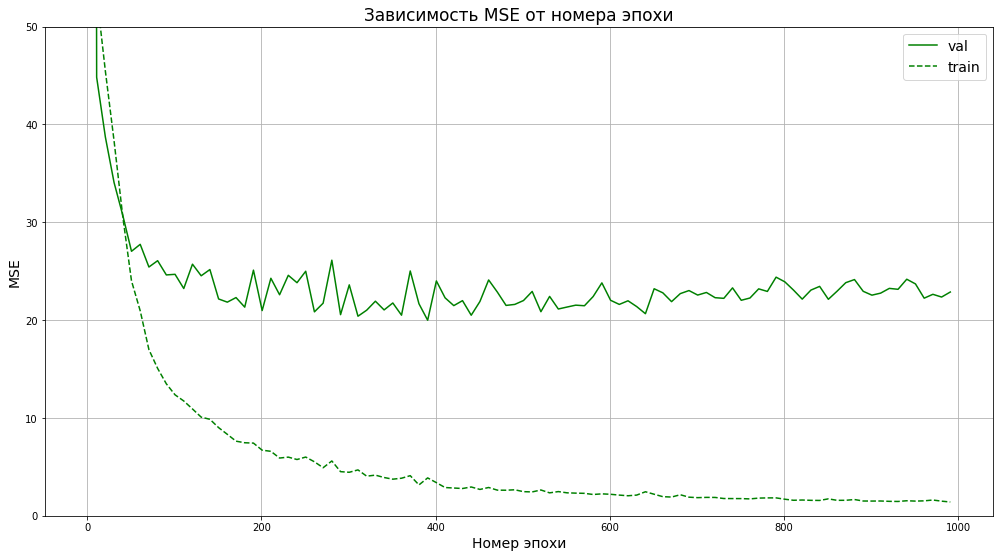

In [ ]:
# Вывод графика
print_graphic(num_epoch, [loss_list_val], "val",
              loss_list_2=[loss_list_train], label_2="train", ylim=(0, 50))

In [ ]:
# Итоговое качество
print(f"MSE на тесте: {val(None, model, criterion, test_dataloader, device):.4f}")
print(f"MSE на валидации: {val(None, model, criterion, val_dataloader, device):.4f}")
print(f"MSE на трейне: {val(None, model, criterion, train_dataloader, device):.4f}")

MSE на тесте: 21.3808
MSE на валидации: 22.8711
MSE на трейне: 1.4109


**Комментарий:** Здесь и далее во всех экспериментах используется $1000$ эпох.

###### Ширина:

In [ ]:
# Параметры
num_epoch = 1000
lr = 0.0001
gamma = 0.5
step_size = 400

train_result_width_list = []
val_result_width_list = []
for width in width_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=5,
                input_dim=13,
                hidden_dim=width,
                output_dim=1,
                batch_norm=True,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_width_list.append(loss_list_val)
    train_result_width_list.append(loss_list_train)

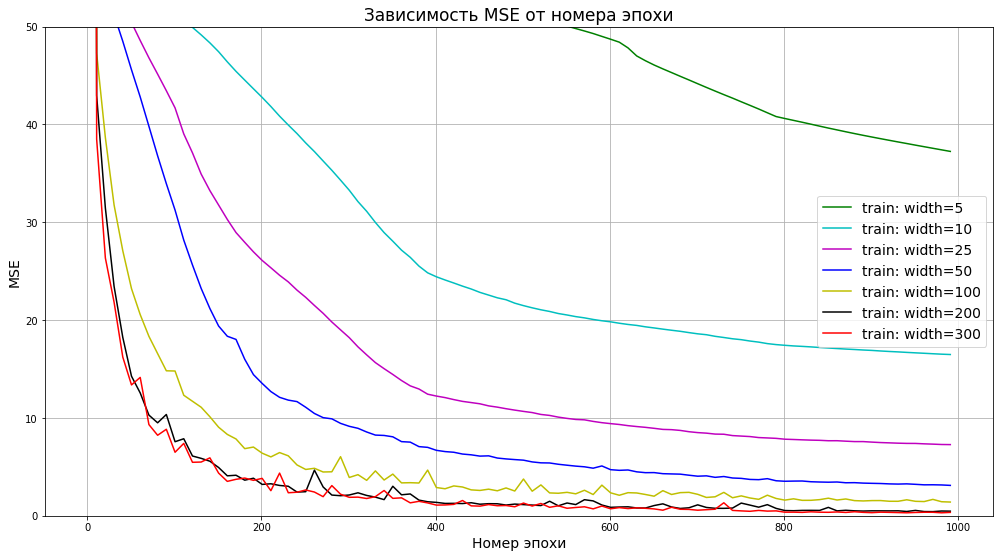

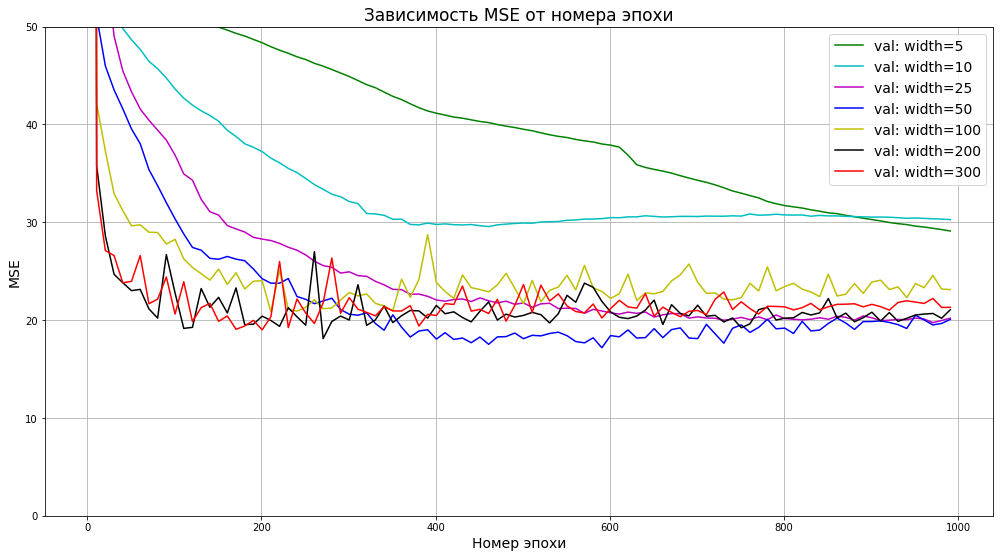

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_width_list, "train: width", parametrs=width_list, ylim=(0, 50))
print_graphic(num_epoch, val_result_width_list, "val: width", parametrs=width_list, ylim=(0, 50))

In [ ]:
# Лучший параметр
best_width = 50

**Результат:** Чем больше ширина слоя, тем, ожидаемо, до меньших значений оптимизируется функция ошибки на тренировочных данных, однако на валидационных данных модели с широкими слоями ($100$, $200$, $300$) быстро достигают небольших значений и начинают переобучаться. Напротив, модели с узкими слоями ($5$, $10$) очень медленно оптимизируются и в данном эксперименте видно, что они не сошлись даже при $1000$ эпохах. Неплохие результаты показывает модель с шириной слоёв, равной $25$, однако в качестве лучшего параметра решено выбрать значение $50$, с которым модель несильно переобучается, но имеет б**о**льший потенциал при использовании различных регуляризаций (дальше).

###### Глубина:

In [ ]:
# Параметры
num_epoch = 1000
lr = 0.0001
gamma = 0.5
step_size = 400

train_result_depth_list = []
val_result_depth_list = []
for depth in depth_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=depth,
                input_dim=13,
                hidden_dim=best_width,
                output_dim=1,
                batch_norm=True,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_depth_list.append(loss_list_val)
    train_result_depth_list.append(loss_list_train)

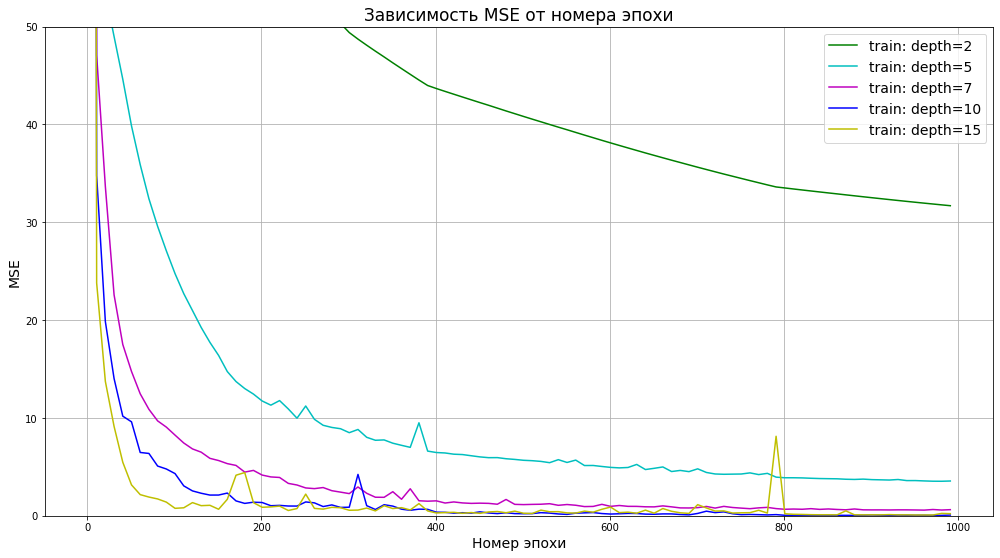

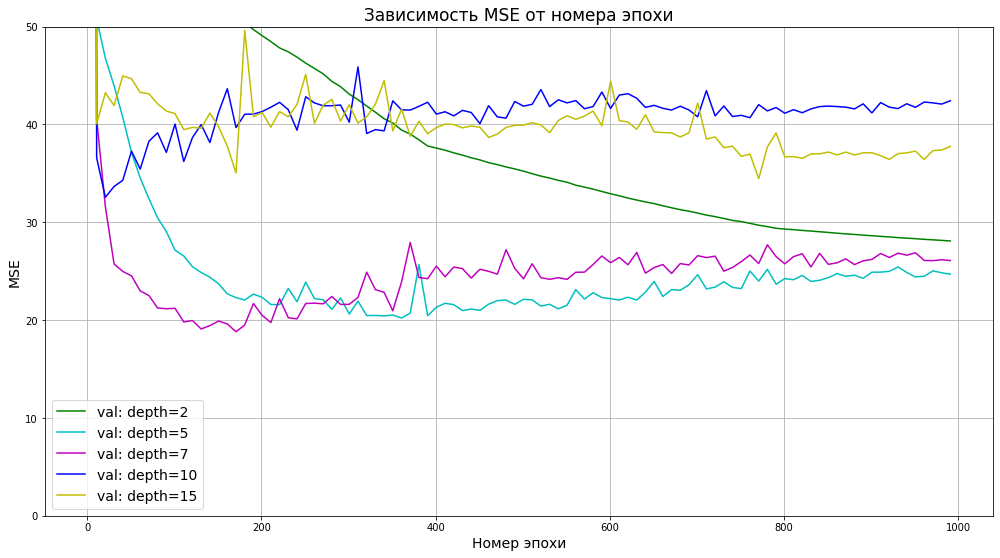

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_depth_list, "train: depth", parametrs=depth_list, ylim=(0, 50))
print_graphic(num_epoch, val_result_depth_list, "val: depth", parametrs=depth_list, ylim=(0, 50))

In [ ]:
# Лучший параметр
best_depth = 5

**Результат:** Аналогично предыдущему эксперименту, чем больше глубина нейросети, тем быстрее оптимизируется функция потерь на тренировочном наборе данных, однако также модели сильно переобучаются - графики унимодальны. Лучшим значением глубины выбрана $5$, модель с которой переобучается, но слабее всего. Сам факт переобучения не очень страшен, так как дальше будут применяться регуляризации и использование методов инициализации, которые помогут решить эту проблему.

###### Batch Normalization:

In [ ]:
# Параметры
num_epoch = 1000
lr = 0.0001
gamma = 0.5
step_size = 400

train_result_batch_norm_list = []
val_result_batch_norm_list = []
for batch_norm in batch_norm_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=13,
                hidden_dim=best_width,
                output_dim=1,
                batch_norm=batch_norm,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_batch_norm_list.append(loss_list_val)
    train_result_batch_norm_list.append(loss_list_train)

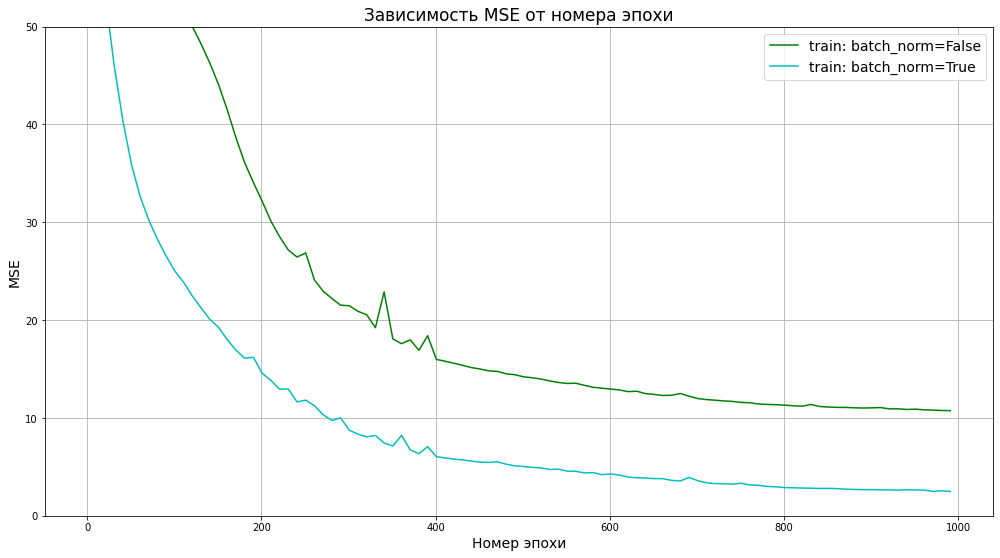

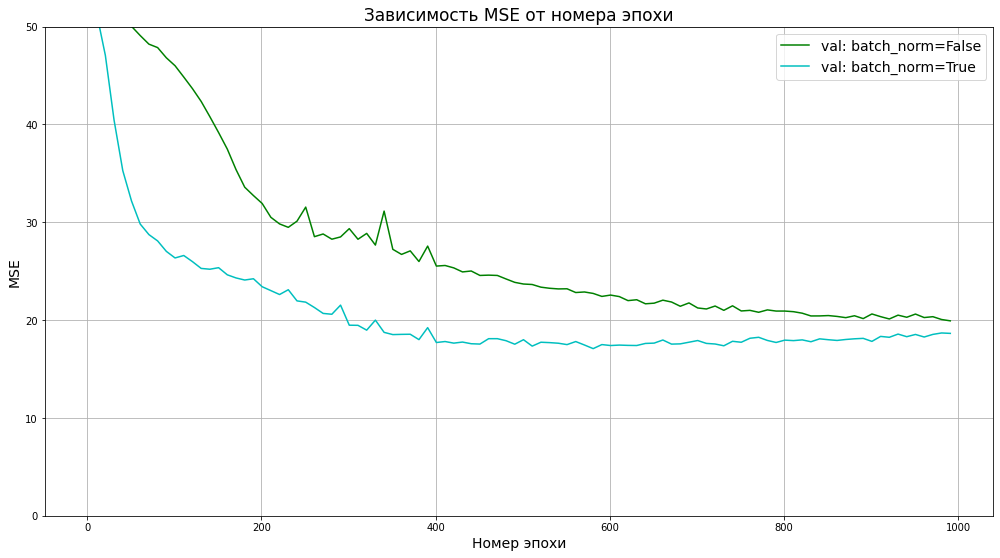

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_batch_norm_list, "train: batch_norm", parametrs=batch_norm_list, ylim=(0, 50))
print_graphic(num_epoch, val_result_batch_norm_list, "val: batch_norm", parametrs=batch_norm_list, ylim=(0, 50))

In [ ]:
# Лучший параметр
best_batch_norm = True

**Результат:** Использование батч-нормализации улучшает сходимость функции потерь на тренировочном и валидационном наборах данных, делая кривую ошибок более гладкой, а линии уровня функции потерь с меньшим числом локальных оптимумов. Поэтому в дальнейшем будем её использовать.

###### Dropout:

In [ ]:
# Параметры
num_epoch = 1000
lr = 0.0001
gamma = 0.5
step_size = 400

train_result_dropout_list = []
val_result_dropout_list = []
for dropout in dropout_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=13,
                hidden_dim=best_width,
                output_dim=1,
                batch_norm=best_batch_norm,
                dropout=dropout,
                init=None,
                act=nn.ReLU)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_dropout_list.append(loss_list_val)
    train_result_dropout_list.append(loss_list_train)

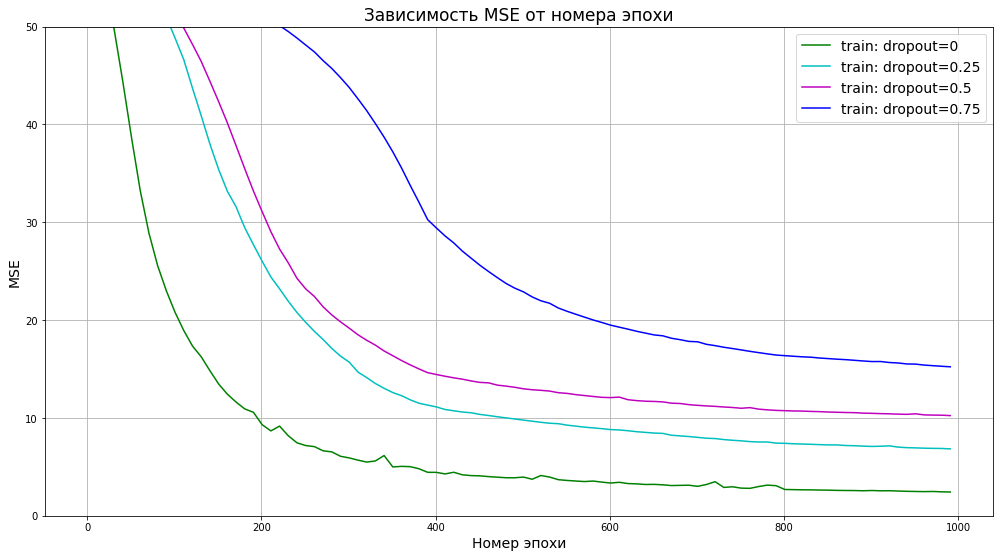

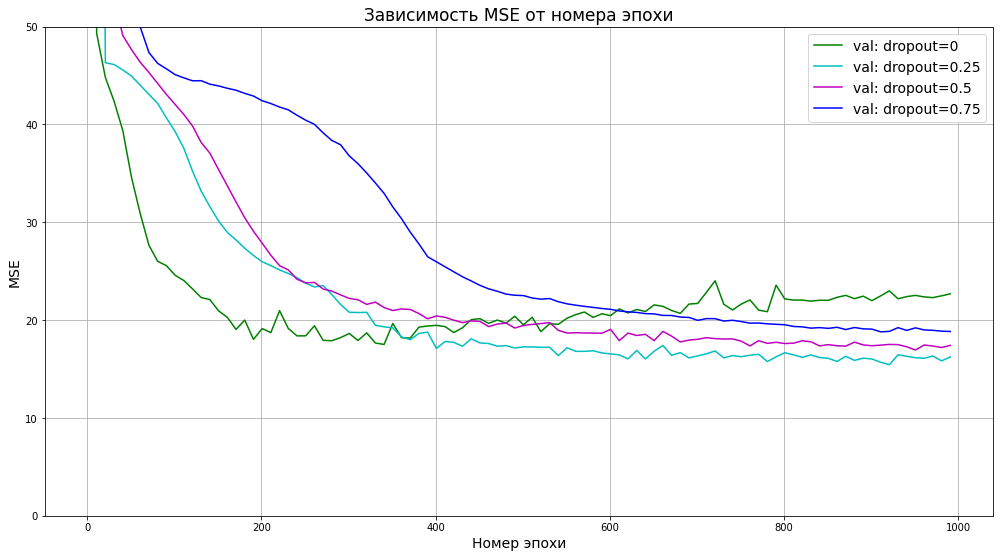

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_dropout_list, "train: dropout", parametrs=dropout_list, ylim=(0, 50))
print_graphic(num_epoch, val_result_dropout_list, "val: dropout", parametrs=dropout_list, ylim=(0, 50))

In [ ]:
# Лучший параметр
best_dropout = 0.25

**Результат:** Видно, что с увеличением dropout, функция потерь на тренировочных данных оптимизируется более плавно. Данный факт улучшает качество, показывающее нейросетью на валидационных данных. Лучшим значением для dropout в рамках $1000$ эпох стало $0.25$. Использование dropout является регуляризатором, который предотвращает раннее переобучение, улучшая обобщающую способность модели.

###### Init:

In [ ]:
# Параметры
num_epoch = 1000
lr = 0.0001
gamma = 0.5
step_size = 400

train_result_init_list = []
val_result_init_list = []
for init in init_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=13,
                hidden_dim=best_width,
                output_dim=1,
                batch_norm=best_batch_norm,
                dropout=best_dropout,
                init=init,
                act=nn.ReLU)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_init_list.append(loss_list_val)
    train_result_init_list.append(loss_list_train)

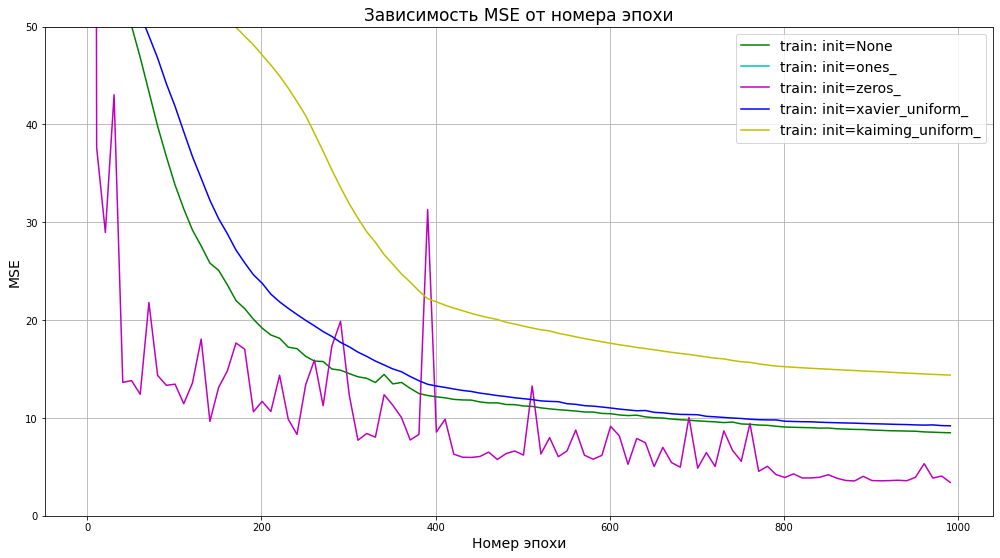

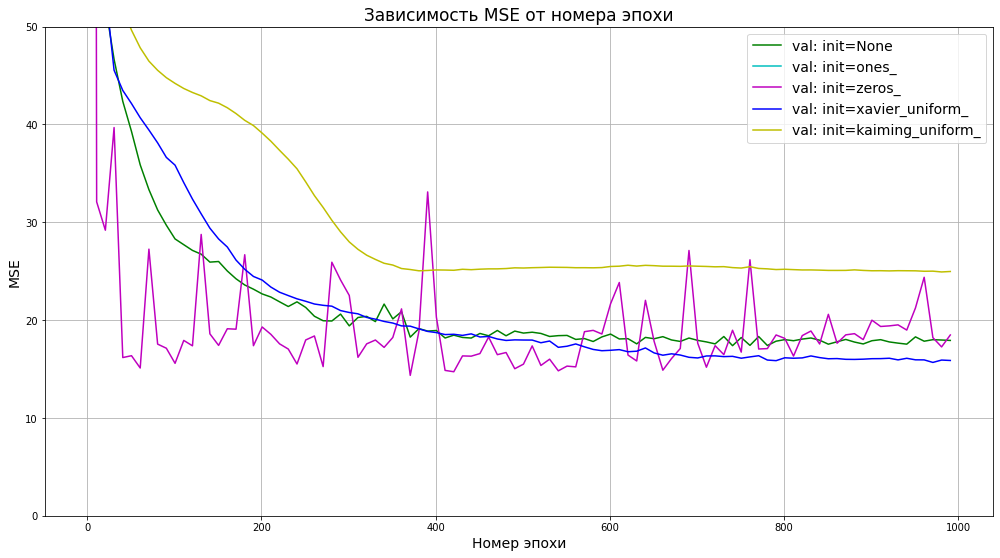

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_init_list, "train: init", parametrs=init_list, ylim=(0, 50))
print_graphic(num_epoch, val_result_init_list, "val: init", parametrs=init_list, ylim=(0, 50))

In [ ]:
# Лучший параметр
best_init = nn.init.xavier_uniform_

**Результат:** На графике видно, насколько неудачные оказались инициализации всюду $0$ или всюду $1$: график для $0$ выглядит просто ужасно, а график для $1$ даже не попал на рисунок, так как при такой инициализации сеть не обучается. Хорошо себя показывает инициализация по умолчанию из равномерного распределения вокруг нуля с масштабом корня из числа экземпляров. Но в данном случае в качестве лучшей инициализации выбран метод **xavier_uniform**. Главное правило для инициализации: сделать так чтобы значения были разные, но лежали около нуля, при этом возможно применять идеи сохранения градиентов и сигналов, которые применяются в именных инициализациях.

###### Активация:

In [ ]:
# Параметры
num_epoch = 1000
lr = 0.0001
gamma = 0.5
step_size = 400

train_result_act_list = []
val_result_act_list = []
for act in act_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=13,
                hidden_dim=best_width,
                output_dim=1,
                batch_norm=best_batch_norm,
                dropout=best_dropout,
                init=best_init,
                act=act)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_act_list.append(loss_list_val)
    train_result_act_list.append(loss_list_train)

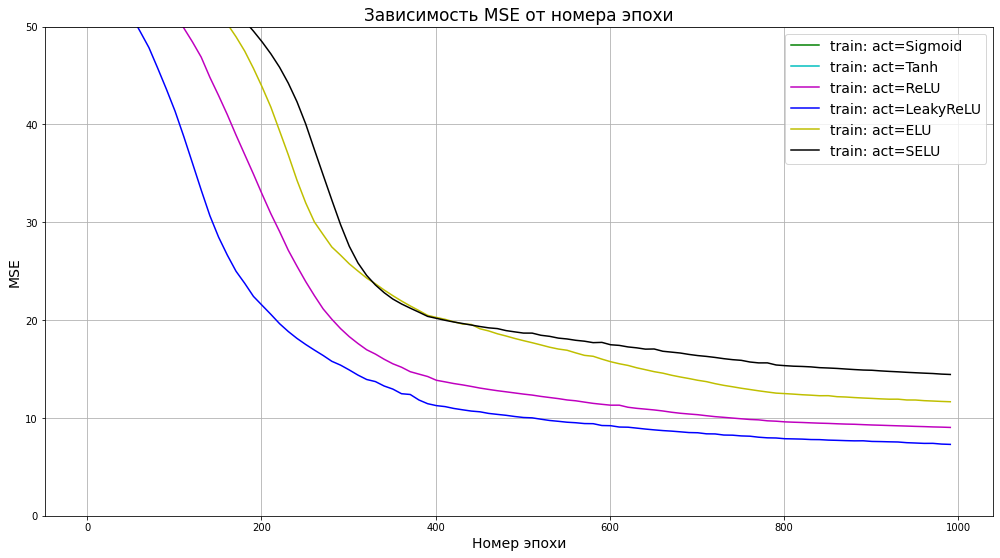

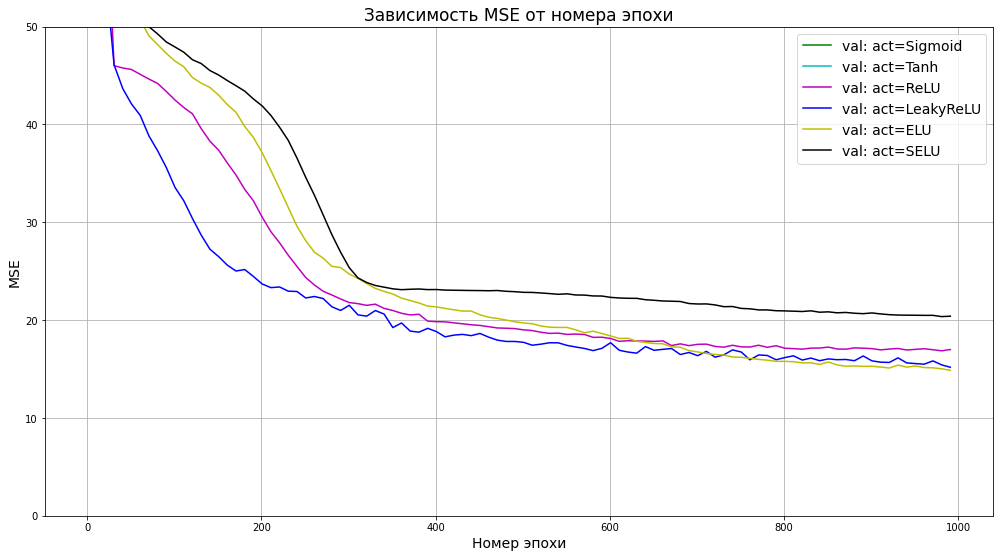

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_act_list, "train: act", parametrs=act_list, ylim=(0, 50))
print_graphic(num_epoch, val_result_act_list, "val: act", parametrs=act_list, ylim=(0, 50))

In [ ]:
# Лучший параметр
best_act = nn.LeakyReLU

**Результат:** При использовании функций потерь **Sigmoid** и **Tanh** сеть не обучается. **ReLU** и **LeakyReLU** показывают похожий неплохой результат. **SELU** работает хуже остальных **ReLU**-подобных функций. В данном случае в качестве лучшей функции потери выбрана **LeakyReLU**. Нет чётких рекомендаций какая **ReLU**-подобная функция активаций в той или иной ситуации будет работать лучше. Одно известно точно: **ReLU** всегда работает лучше сигмоидальных функций (есть много формальных и неформальных объяснений).

###### Финальный тест:

In [ ]:
# Параметры
num_epoch = 1000
lr = 0.0001
gamma = 0.5
step_size = 400

# Модель, функция потерь, ...
model = FFN(num_layers=best_depth,
            input_dim=13,
            hidden_dim=best_width,
            output_dim=1,
            batch_norm=best_batch_norm,
            dropout=best_dropout,
            init=best_init,
            act=best_act)
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

# Обучение
loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, 
                                       train_dataloader, val_dataloader, device, scheduler)

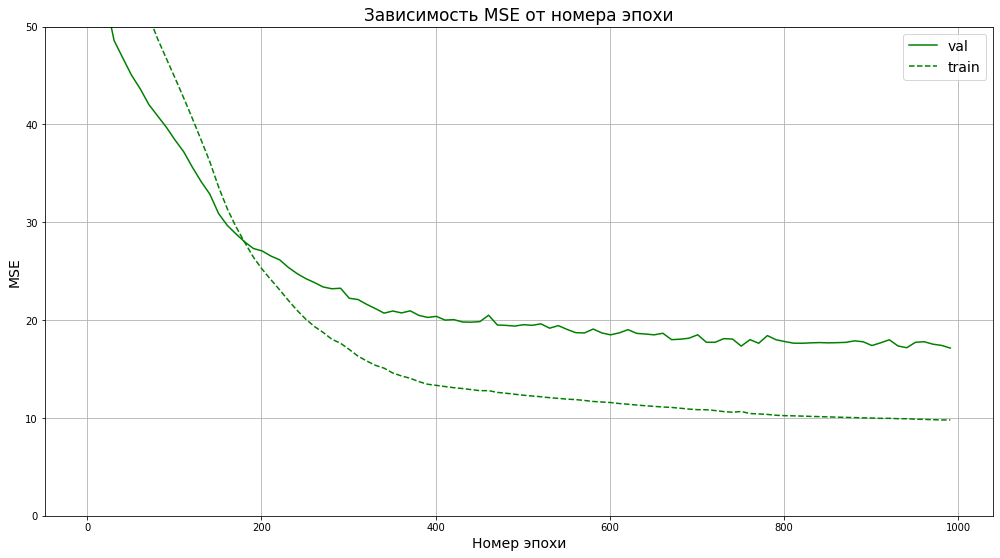

In [ ]:
# Вывод графика
print_graphic(num_epoch, [loss_list_val], "val",
              loss_list_2=[loss_list_train], label_2="train", ylim=(0, 50))

In [ ]:
# Итоговое качество
print(f"MSE на тесте: {val(None, model, criterion, test_dataloader, device):.4f}")
print(f"MSE на валидации: {val(None, model, criterion, val_dataloader, device):.4f}")
print(f"MSE на трейне: {val(None, model, criterion, train_dataloader, device):.4f}")

MSE на тесте: 18.1441
MSE на валидации: 17.1417
MSE на трейне: 9.8024


**Вывод:** Улучшение по сравнению с первоначальным измерением есть, но оно небольшое. С другой стороны сразу была выбрана хорошая функция активации **ReLU**, сразу была использована батч-нормализация и адекватная ширина и глубина.

##### **Iris plants dataset (classification)**

In [ ]:
# Параметры
batch_size = 8
weight_decay = 1e-5


depth_list = [1, 2, 3, 4, 5, 7] # 6
width_list = [2, 3, 4, 5, 6, 7] # 6
batch_norm_list = [False, True] # 2
dropout_list = [0, 0.25, 0.5, 0.75] # 4
init_list = [None, nn.init.ones_, nn.init.zeros_,
             nn.init.xavier_uniform_, nn.init.kaiming_uniform_] # 5
act_list = [nn.Sigmoid, nn.Tanh, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.SELU] # 6

In [ ]:
# Загрузка данных
train_dataloader, test_dataloader, val_dataloader = load_dataset("iris", batch_size)

X.shape: (150, 4), y.shape: (150,)
Train samples: 90
Test samples: 30
Val samples: 30


###### Тестовый запуск:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

# Модель, функция потерь, ...
model = FFN(num_layers=2,
            input_dim=4,
            hidden_dim=2,
            output_dim=3,
            batch_norm=False,
            dropout=0,
            init=None,
            act=nn.ReLU)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

# Обучение
loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                       val_dataloader, device, scheduler, clf_flag=True)

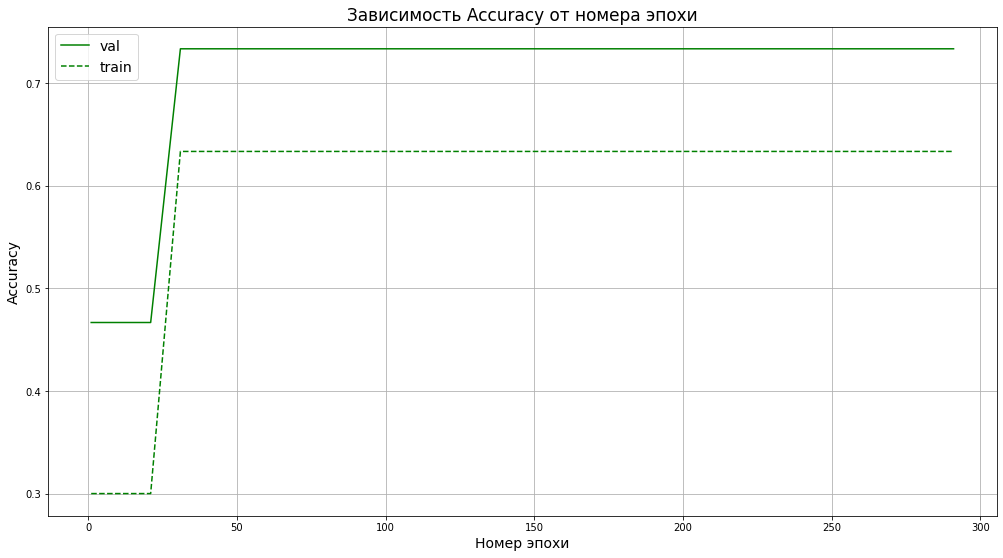

In [ ]:
# Вывод графика
print_graphic(num_epoch, [loss_list_val], "val",
              loss_list_2=[loss_list_train], label_2="train", ylim=None, clf_flag=True)

In [ ]:
# Итоговое качество
print(f"Accuracy на тесте: {val(None, model, criterion, test_dataloader, device, clf_flag=True):.4f}")
print(f"Accuracy на валидации: {val(None, model, criterion, val_dataloader, device, clf_flag=True):.4f}")
print(f"Accuracy на трейне: {val(None, model, criterion, train_dataloader, device, clf_flag=True):.4f}")

Accuracy на тесте: 0.7000
Accuracy на валидации: 0.7333
Accuracy на трейне: 0.6333


###### Ширина:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_width_list = []
val_result_width_list = []
for width in width_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=2,
                input_dim=4,
                hidden_dim=width,
                output_dim=3,
                batch_norm=False,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_width_list.append(loss_list_val)
    train_result_width_list.append(loss_list_train)

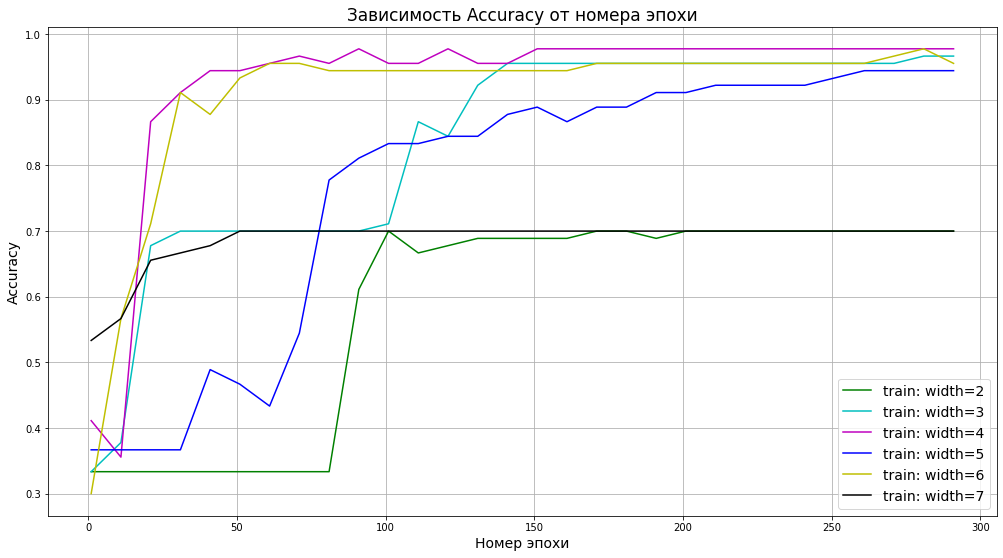

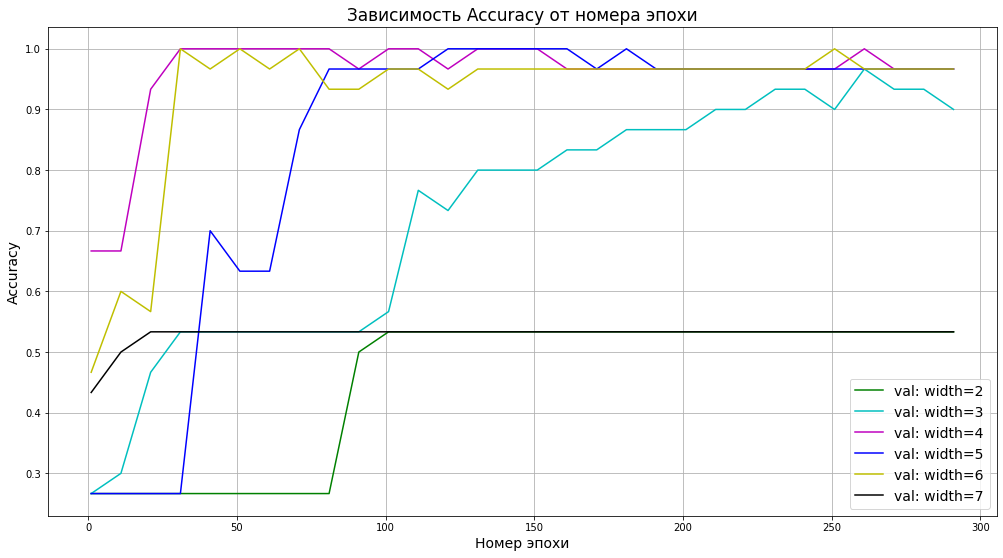

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_width_list, "train: width", parametrs=width_list, clf_flag=True)
print_graphic(num_epoch, val_result_width_list, "val: width", parametrs=width_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_width = 4

**Результат:** Маленькие значения ширины ($2$, $3$) либо показывают низкое качество, либо долго обучаются. Сети с слишком большими значениями ($7$) также показывают низкое качество. Лучшим значением выбрана ширина, равная $4$.

###### Глубина:

In [ ]:
depth_list

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_depth_list = []
val_result_depth_list = []
for depth in depth_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=depth,
                input_dim=4,
                hidden_dim=best_width,
                output_dim=3,
                batch_norm=False,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_depth_list.append(loss_list_val)
    train_result_depth_list.append(loss_list_train)

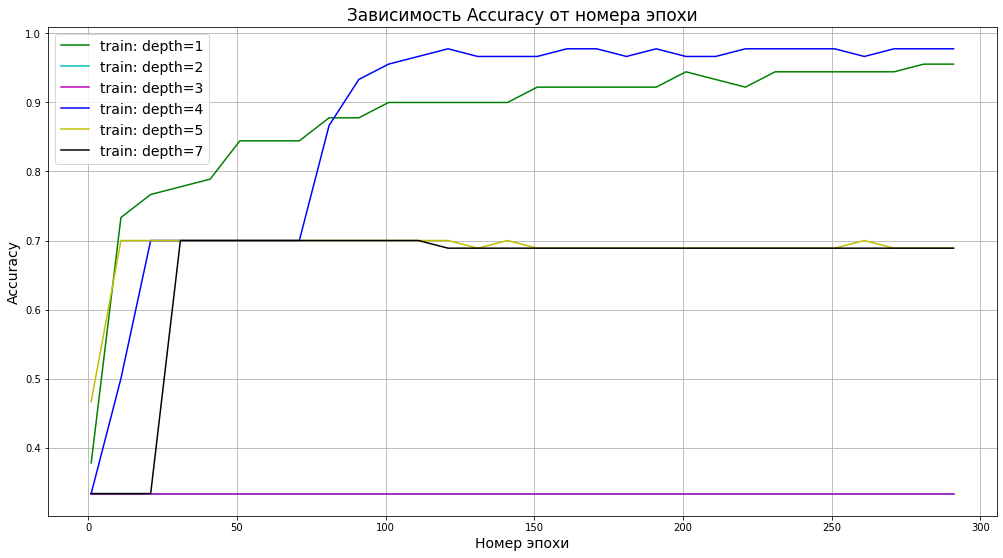

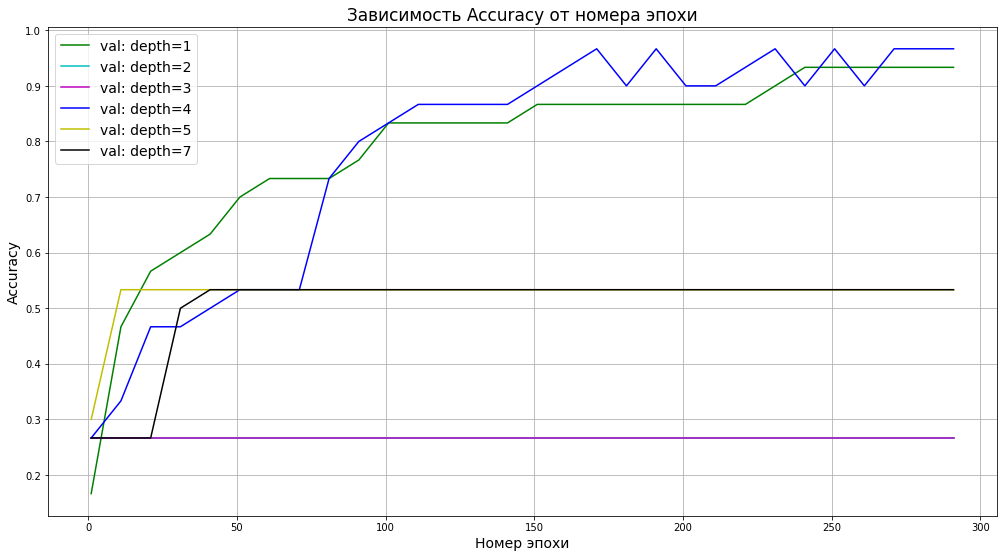

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_depth_list, "train: depth", parametrs=depth_list, clf_flag=True)
print_graphic(num_epoch, val_result_depth_list, "val: depth", parametrs=depth_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_depth = 4

**Результат:** Графики получились неоднозначными. Лучшее значение глубины выбрано равным $4$.

###### Batch Normalization:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_batch_norm_list = []
val_result_batch_norm_list = []
for batch_norm in batch_norm_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=4,
                hidden_dim=best_width,
                output_dim=3,
                batch_norm=batch_norm,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_batch_norm_list.append(loss_list_val)
    train_result_batch_norm_list.append(loss_list_train)

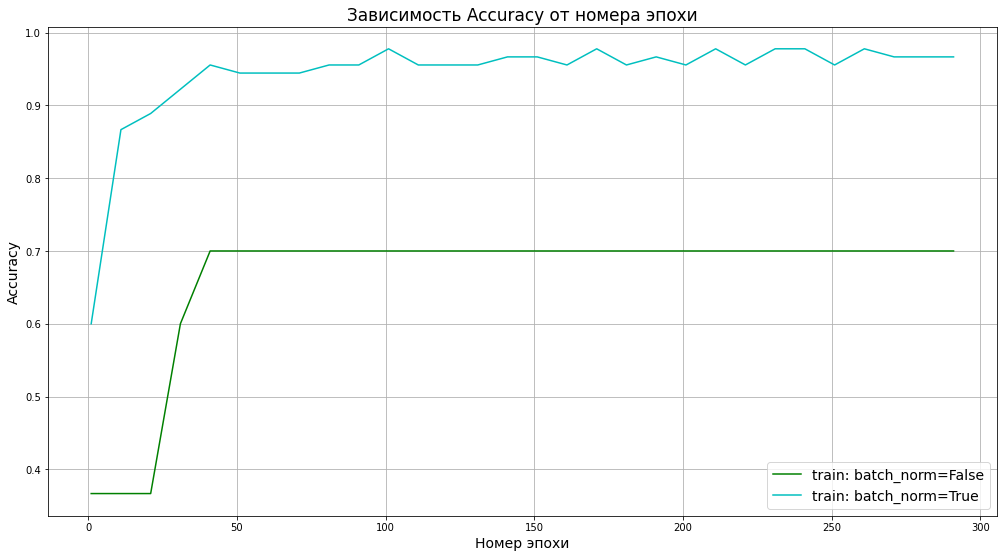

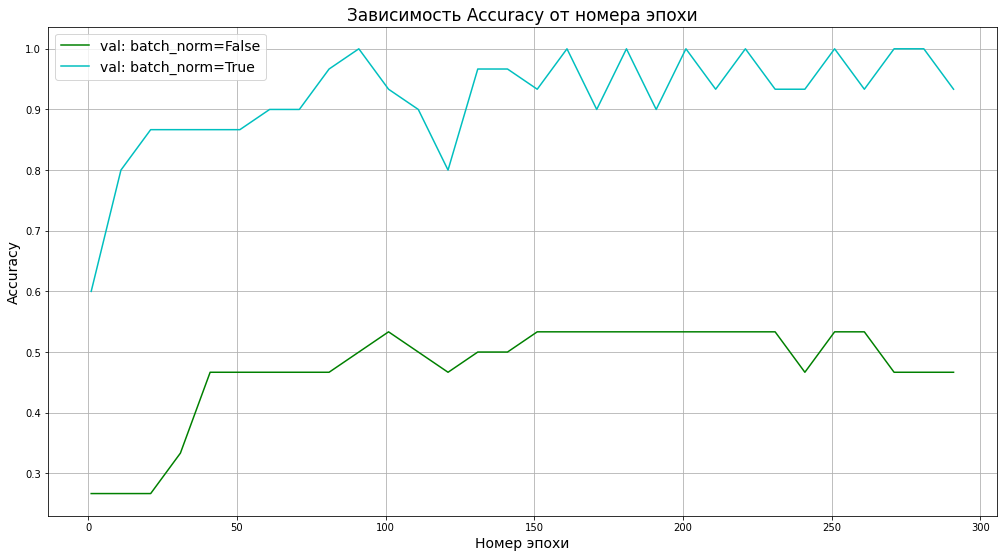

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_batch_norm_list, "train: batch_norm", parametrs=batch_norm_list, clf_flag=True)
print_graphic(num_epoch, val_result_batch_norm_list, "val: batch_norm", parametrs=batch_norm_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_batch_norm = True

**Результат:** Использование батч-нормализации позитивно сказывается на точности. Будем её использовать.

###### Dropout:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_dropout_list = []
val_result_dropout_list = []
for dropout in dropout_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=4,
                hidden_dim=best_width,
                output_dim=3,
                batch_norm=best_batch_norm,
                dropout=dropout,
                init=None,
                act=nn.ReLU)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_dropout_list.append(loss_list_val)
    train_result_dropout_list.append(loss_list_train)

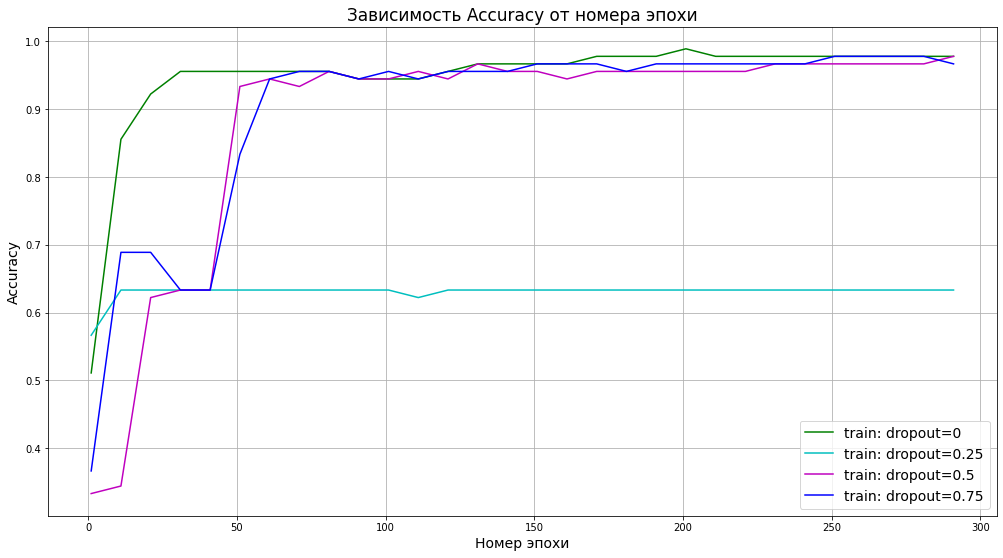

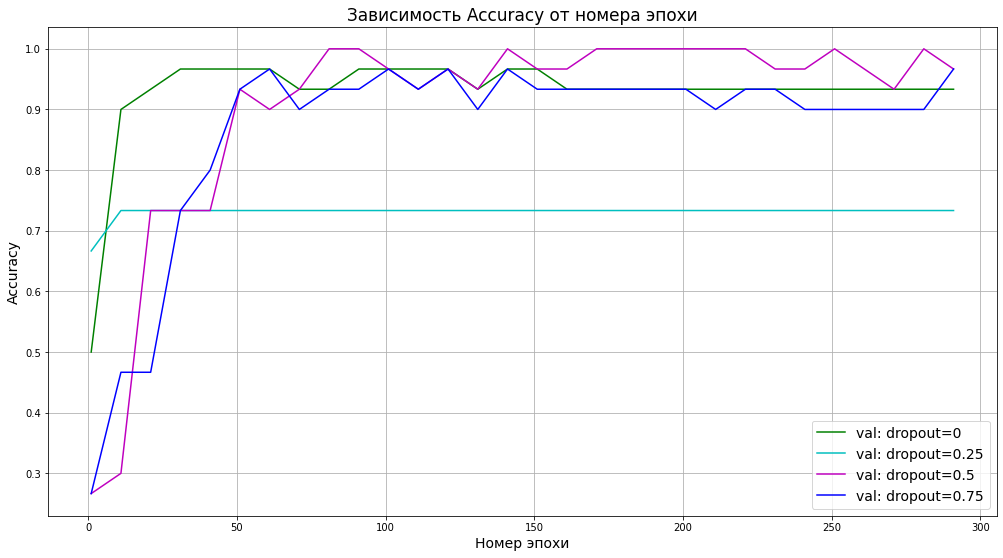

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_dropout_list, "train: dropout", parametrs=dropout_list, clf_flag=True)
print_graphic(num_epoch, val_result_dropout_list, "val: dropout", parametrs=dropout_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_dropout = 0

**Результат:** Присутствие dropout не улучшает качество. В нашем случае сеть не переобучается, поэтому нет необходимости использовать dropout, который является регуляризатором сетей.

###### Init:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_init_list = []
val_result_init_list = []
for init in init_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=4,
                hidden_dim=best_width,
                output_dim=3,
                batch_norm=best_batch_norm,
                dropout=best_dropout,
                init=init,
                act=nn.ReLU)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_init_list.append(loss_list_val)
    train_result_init_list.append(loss_list_train)

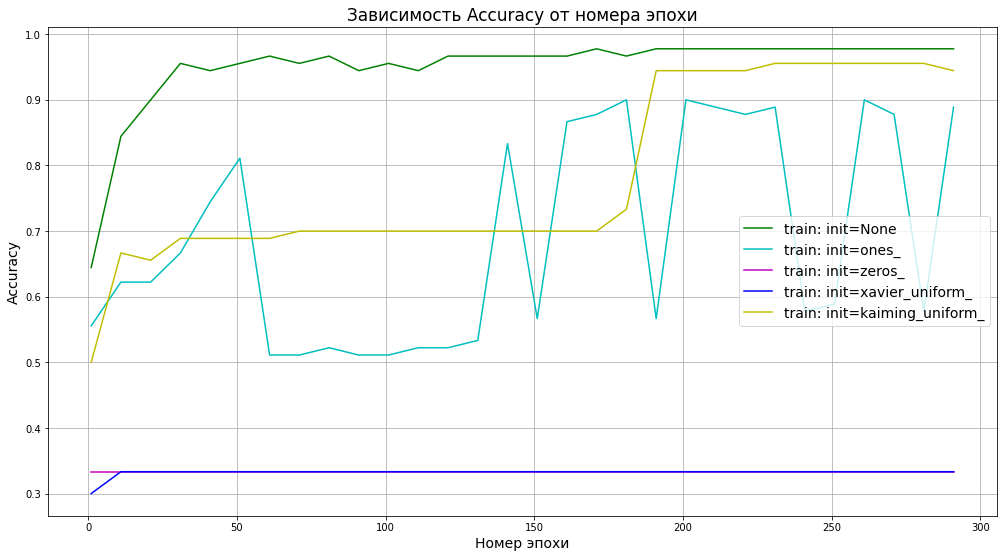

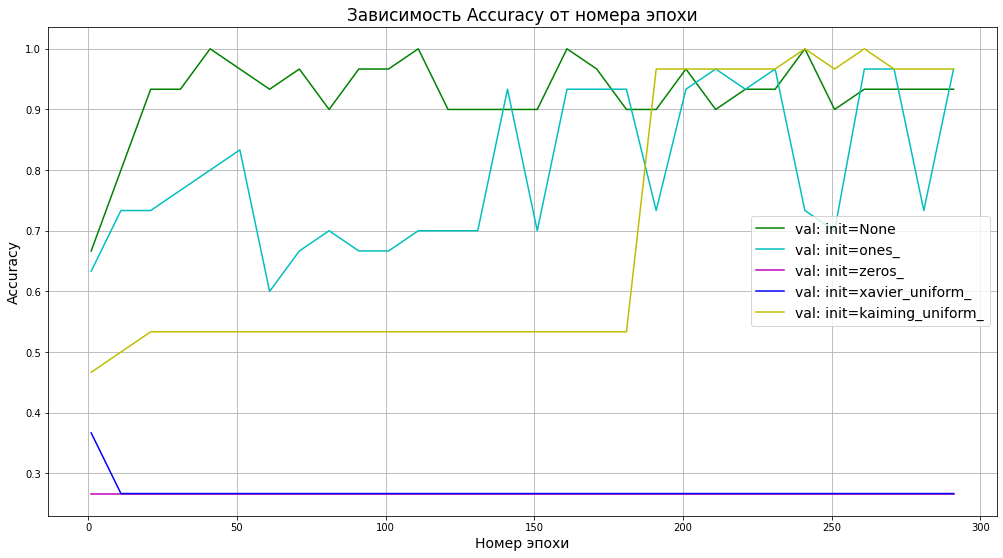

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_init_list, "train: init", parametrs=init_list, clf_flag=True)
print_graphic(num_epoch, val_result_init_list, "val: init", parametrs=init_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_init = None

**Результат:** В данном случае лучшим методом инициализации оказалась инициализация по умолчанию. Инициализация одними единицами очень не устойчива, инициализация нулями не позволяет сети обучаться. Именные инициализации также показывают неудовлетворительные результаты.

###### Активация:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_act_list = []
val_result_act_list = []
for act in act_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=4,
                hidden_dim=best_width,
                output_dim=3,
                batch_norm=best_batch_norm,
                dropout=best_dropout,
                init=best_init,
                act=act)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_act_list.append(loss_list_val)
    train_result_act_list.append(loss_list_train)

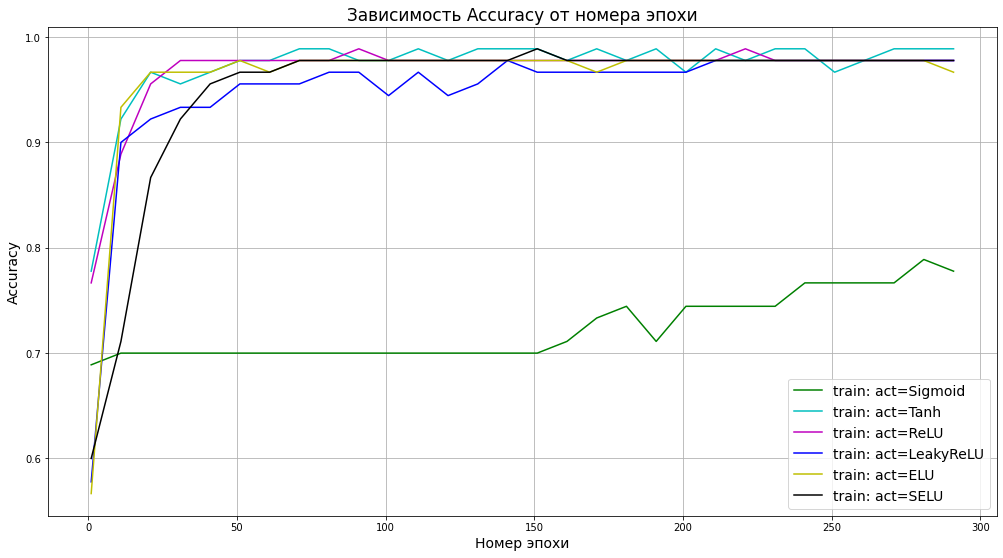

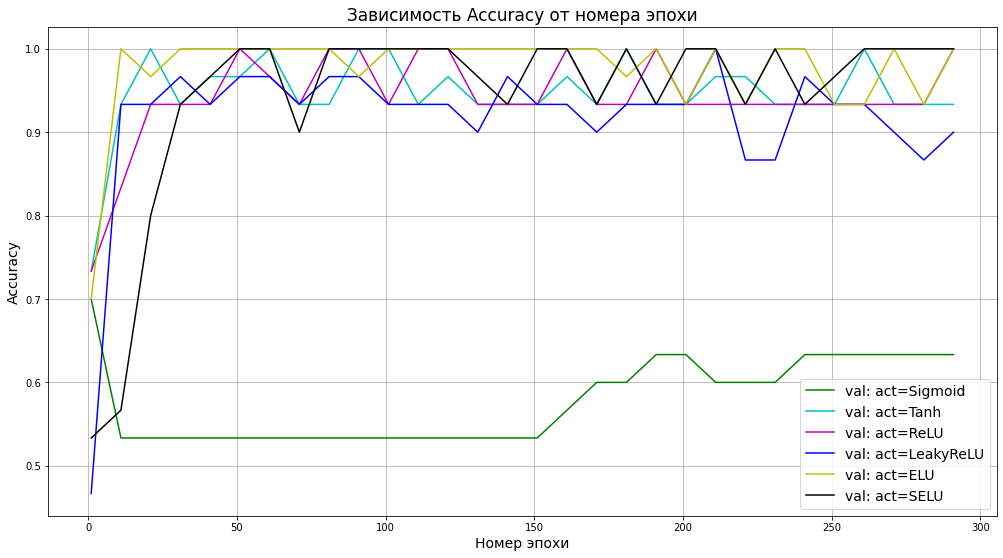

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_act_list, "train: act", parametrs=act_list, clf_flag=True)
print_graphic(num_epoch, val_result_act_list, "val: act", parametrs=act_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_act = nn.ELU

**Результат:** Сигмоида не позволяет сети обучаться. Все остальные функции активации ведут себя похожим образом. В качестве лучшей функции активации выберем **ELU**.

###### Финальный тест:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

# Модель, функция потерь, ...
model = FFN(num_layers=best_depth,
            input_dim=4,
            hidden_dim=best_width,
            output_dim=3,
            batch_norm=best_batch_norm,
            dropout=best_dropout,
            init=best_init,
            act=best_act)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

# Обучение
loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                       val_dataloader, device, scheduler, clf_flag=True)

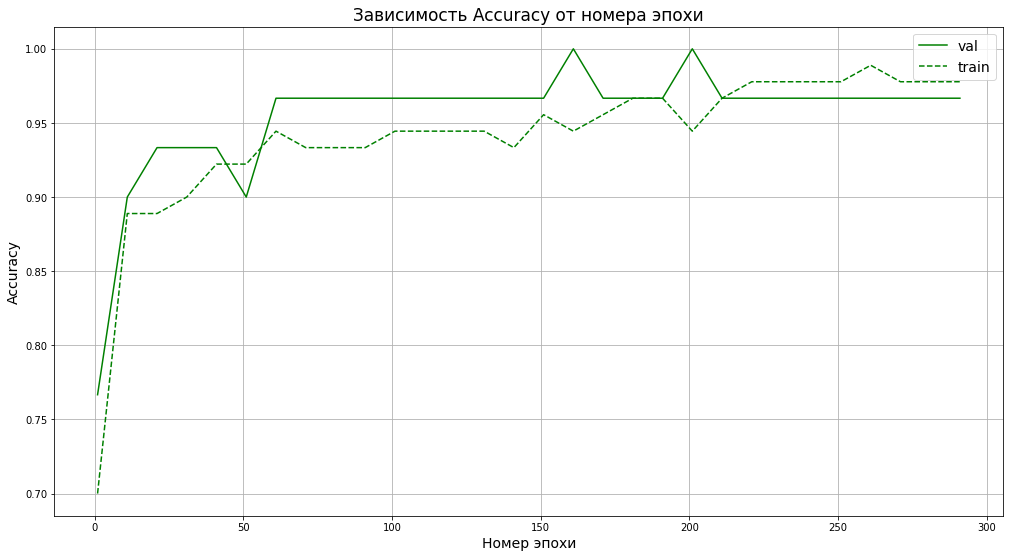

In [ ]:
# Вывод графика
print_graphic(num_epoch, [loss_list_val], "val",
              loss_list_2=[loss_list_train], label_2="train", clf_flag=True)

In [ ]:
# Итоговое качество
print(f"Accuracy на тесте: {val(None, model, criterion, test_dataloader, device, clf_flag=True):.4f}")
print(f"Accuracy на валидации: {val(None, model, criterion, val_dataloader, device, clf_flag=True):.4f}")
print(f"Accuracy на трейне: {val(None, model, criterion, train_dataloader, device, clf_flag=True):.4f}")

Accuracy на тесте: 0.9667
Accuracy на валидации: 0.9667
Accuracy на трейне: 0.9778


**Вывод:** Задача очень простая, поэтому даже небольшое улучшение исходной сети даёт хорошее качество.

##### **Diabetes dataset (regression)**

In [ ]:
# Параметры
batch_size = 32
weight_decay = 1e-5


depth_list = [2, 4, 6, 8, 10, 15] # 6
width_list = [5, 10, 25, 50, 100] # 5
batch_norm_list = [False, True] # 2
dropout_list = [0, 0.25, 0.5, 0.75] # 4
init_list = [None, nn.init.ones_, nn.init.zeros_,
             nn.init.xavier_uniform_, nn.init.kaiming_uniform_] # 5
act_list = [nn.Sigmoid, nn.Tanh, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.SELU] # 6

In [ ]:
# Загрузка данных
train_dataloader, test_dataloader, val_dataloader = load_dataset("diabetes", batch_size)

X.shape: (442, 10), y.shape: (442,)
Train samples: 264
Test samples: 89
Val samples: 89


###### Тестовый запуск:

In [ ]:
# Параметры
num_epoch = 100
lr = 0.01
gamma = 0.5
step_size = 100

# Модель, функция потерь, ...
model = FFN(num_layers=4,
            input_dim=10,
            hidden_dim=5,
            output_dim=1,
            batch_norm=True,
            dropout=0,
            init=None,
            act=nn.ReLU)
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

# Обучение
loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, 
                                       train_dataloader, val_dataloader, device, scheduler)

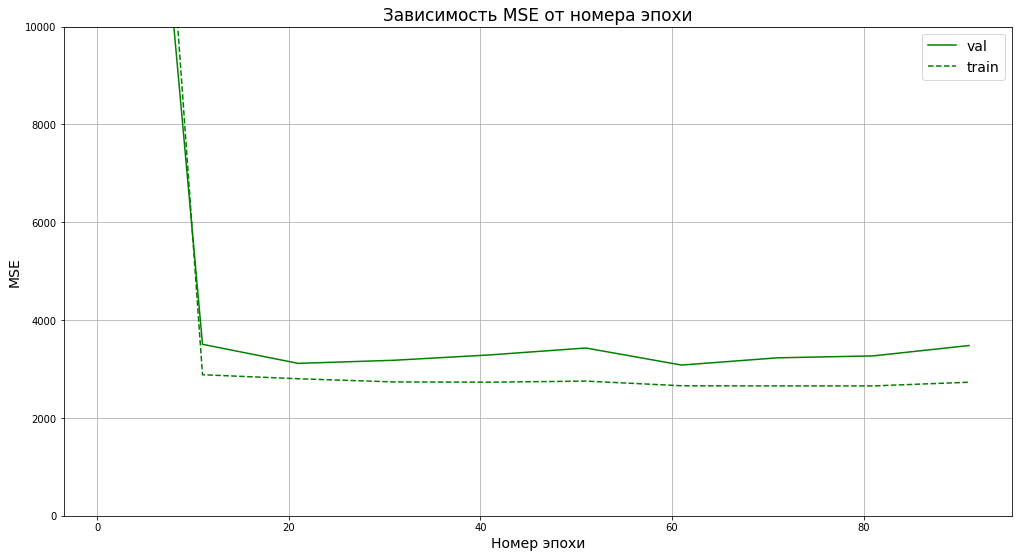

In [ ]:
# Вывод графика
print_graphic(num_epoch, [loss_list_val], "val",
              loss_list_2=[loss_list_train], label_2="train", ylim=(0, 10000))

In [ ]:
print(f"MSE на тесте: {val(None, model, criterion, test_dataloader, device):.4f}")
print(f"MSE на валидации: {val(None, model, criterion, val_dataloader, device):.4f}")
print(f"MSE на трейне: {val(None, model, criterion, train_dataloader, device):.4f}")

MSE на тесте: 3140.0573
MSE на валидации: 3480.5925
MSE на трейне: 2730.5115


**Комментарий:** Сеть переобучается, если использовать больше $100$ эпох. Дальнейшие эксперименты проводятся на $300$ эпохах. Финальный тест также будет использовать оптимальное количество эпох.

###### Ширина:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.01
gamma = 0.5
step_size = 300

train_result_width_list = []
val_result_width_list = []
for width in width_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=4,
                input_dim=10,
                hidden_dim=width,
                output_dim=1,
                batch_norm=True,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_width_list.append(loss_list_val)
    train_result_width_list.append(loss_list_train)

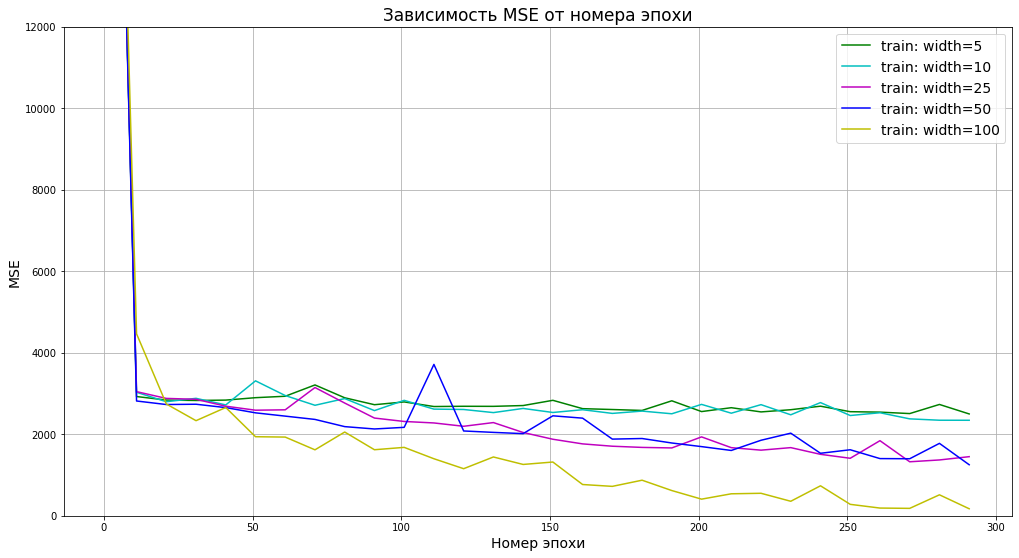

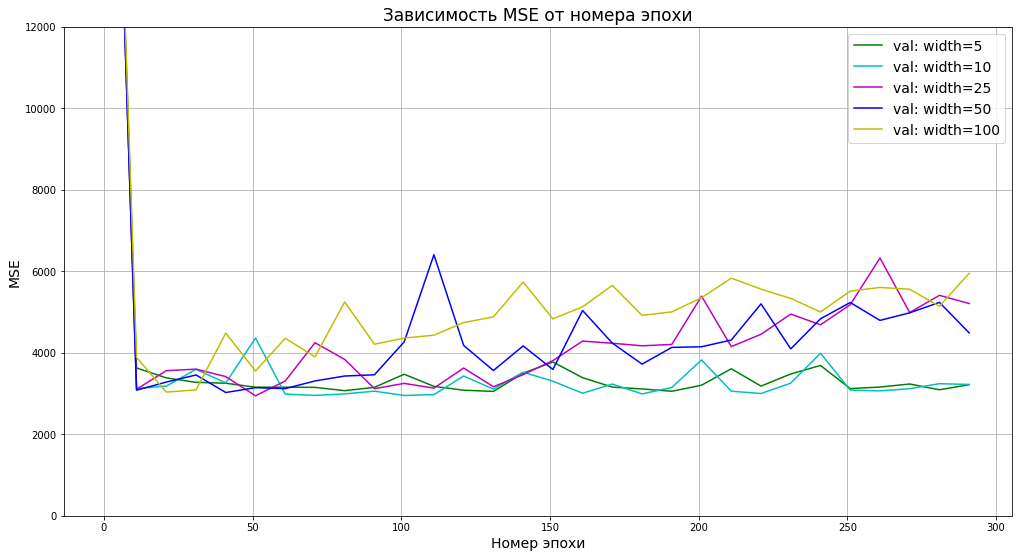

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_width_list, "train: width", parametrs=width_list, ylim=(0, 12000))
print_graphic(num_epoch, val_result_width_list, "val: width", parametrs=width_list, ylim=(0, 12000))

In [ ]:
# Лучший параметр
best_width = 10

**Результат:** С увеличением ширины слоя увеличивается переобучение сети. Лучшим значением ширины выбрано $10$.

###### Глубина:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.01
gamma = 0.5
step_size = 300

train_result_depth_list = []
val_result_depth_list = []
for depth in depth_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=depth,
                input_dim=10,
                hidden_dim=best_width,
                output_dim=1,
                batch_norm=True,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_depth_list.append(loss_list_val)
    train_result_depth_list.append(loss_list_train)

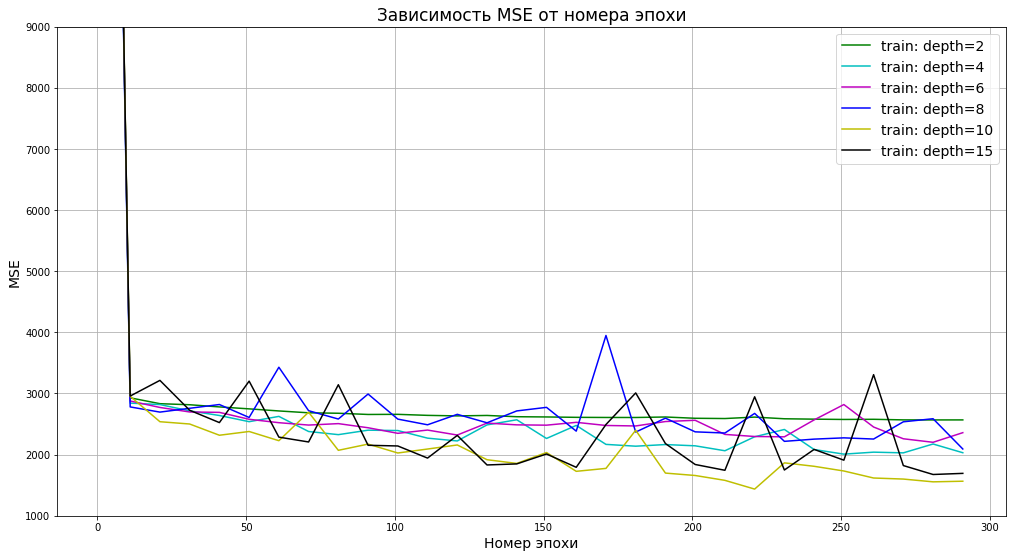

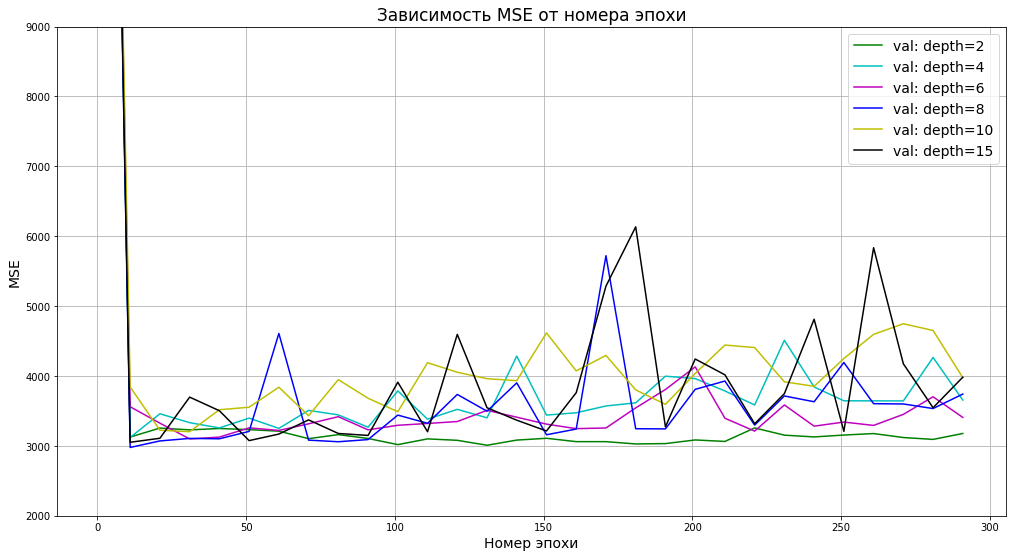

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_depth_list, "train: depth", parametrs=depth_list, ylim=(1000, 9000))
print_graphic(num_epoch, val_result_depth_list, "val: depth", parametrs=depth_list, ylim=(2000, 9000))

In [ ]:
# Лучший параметр
best_depth = 2

**Результат:** С увеличением глубины слоя увеличивается переобучение сети, график потерь на валидации становится очень неустойчивым. Также видно, что увеличение глубины не приводит к обнулению потерь на тренировочных данных за $300$ эпох. Лучшее значение глубины равно $2$.

###### Batch Normalization:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.01
gamma = 0.5
step_size = 300

train_result_batch_norm_list = []
val_result_batch_norm_list = []
for batch_norm in batch_norm_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=10,
                hidden_dim=best_width,
                output_dim=1,
                batch_norm=batch_norm,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_batch_norm_list.append(loss_list_val)
    train_result_batch_norm_list.append(loss_list_train)

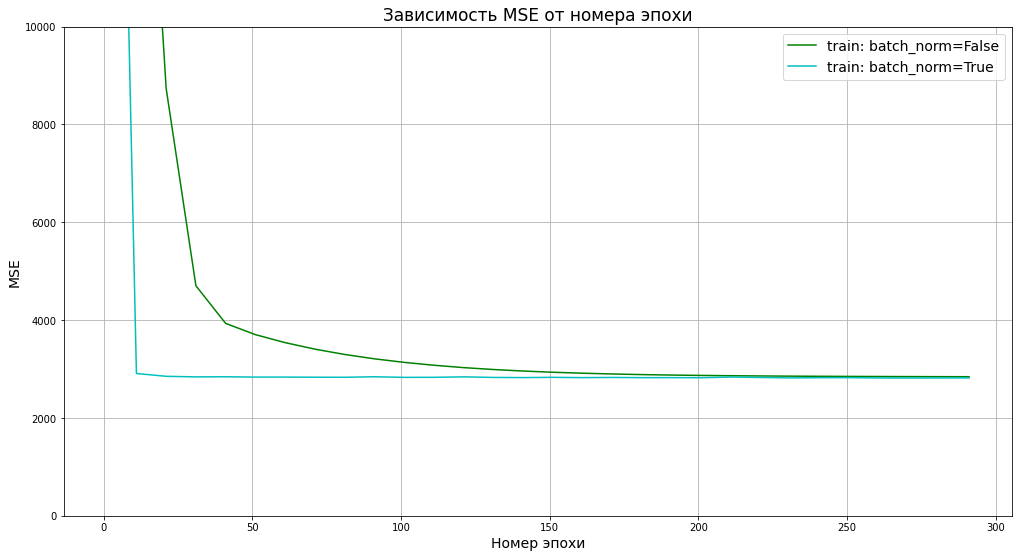

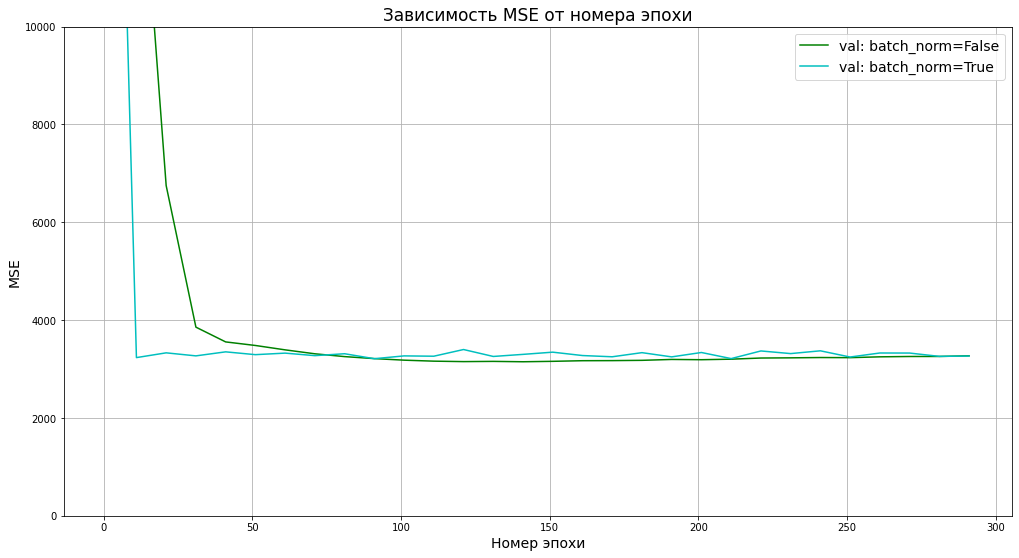

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_batch_norm_list, "train: batch_norm", parametrs=batch_norm_list, ylim=(0, 10000))
print_graphic(num_epoch, val_result_batch_norm_list, "val: batch_norm", parametrs=batch_norm_list, ylim=(0, 10000))

In [ ]:
# Лучший параметр
best_batch_norm = True

**Результат:** Использование батч-нормализации ускоряет сходимость функции потерь на валидационном и тренировочном наборах данных. Далее будем её использовать.

###### Dropout:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.01
gamma = 0.5
step_size = 300

train_result_dropout_list = []
val_result_dropout_list = []
for dropout in dropout_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=10,
                hidden_dim=best_width,
                output_dim=1,
                batch_norm=best_batch_norm,
                dropout=dropout,
                init=None,
                act=nn.ReLU)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_dropout_list.append(loss_list_val)
    train_result_dropout_list.append(loss_list_train)

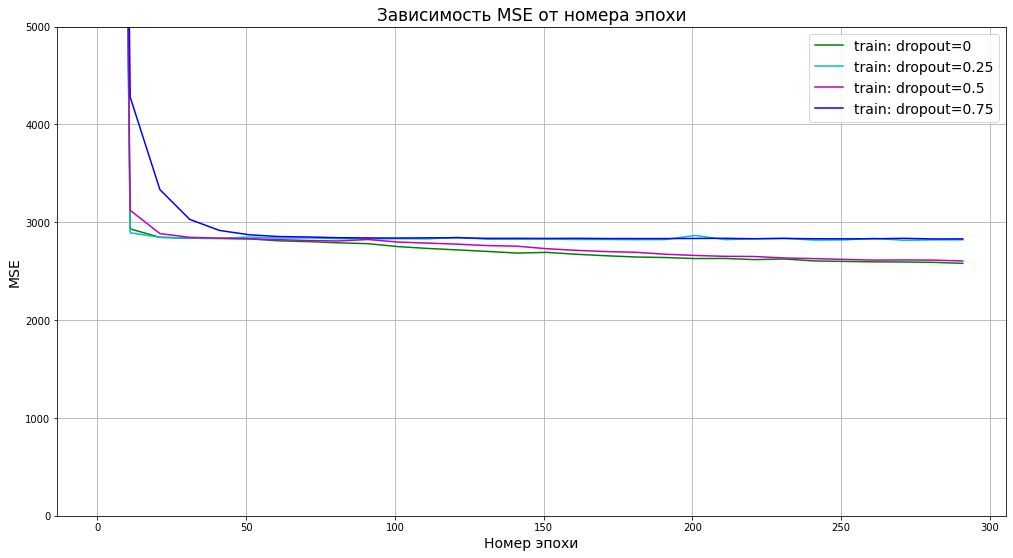

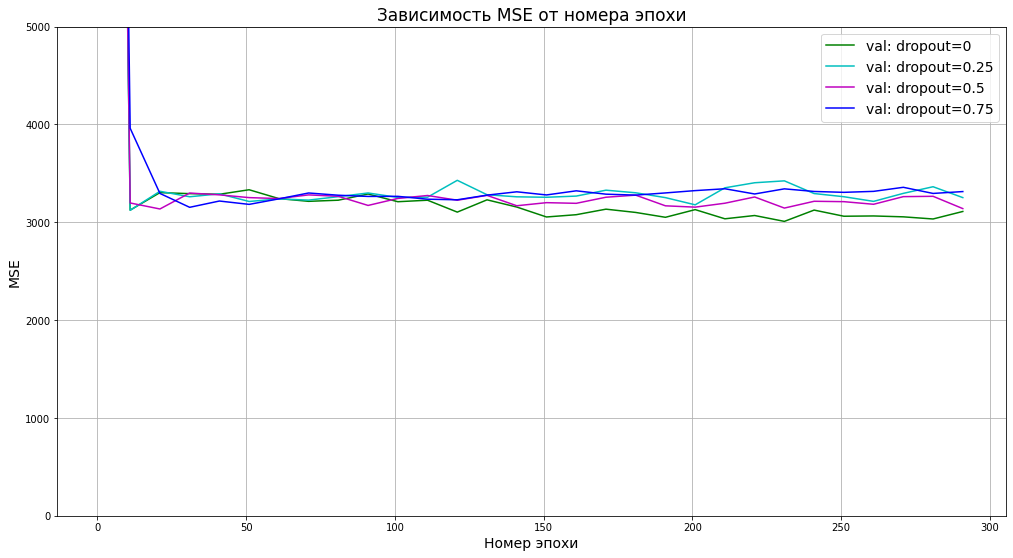

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_dropout_list, "train: dropout", parametrs=dropout_list, ylim=(0, 5000))
print_graphic(num_epoch, val_result_dropout_list, "val: dropout", parametrs=dropout_list, ylim=(0, 5000))

In [ ]:
# Лучший параметр
best_dropout = 0

**Результат:** Сеть без использования dropout показывает лучшее качество.

###### Init:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.01
gamma = 0.5
step_size = 300

train_result_init_list = []
val_result_init_list = []
for init in init_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=10,
                hidden_dim=best_width,
                output_dim=1,
                batch_norm=best_batch_norm,
                dropout=best_dropout,
                init=init,
                act=nn.ReLU)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_init_list.append(loss_list_val)
    train_result_init_list.append(loss_list_train)

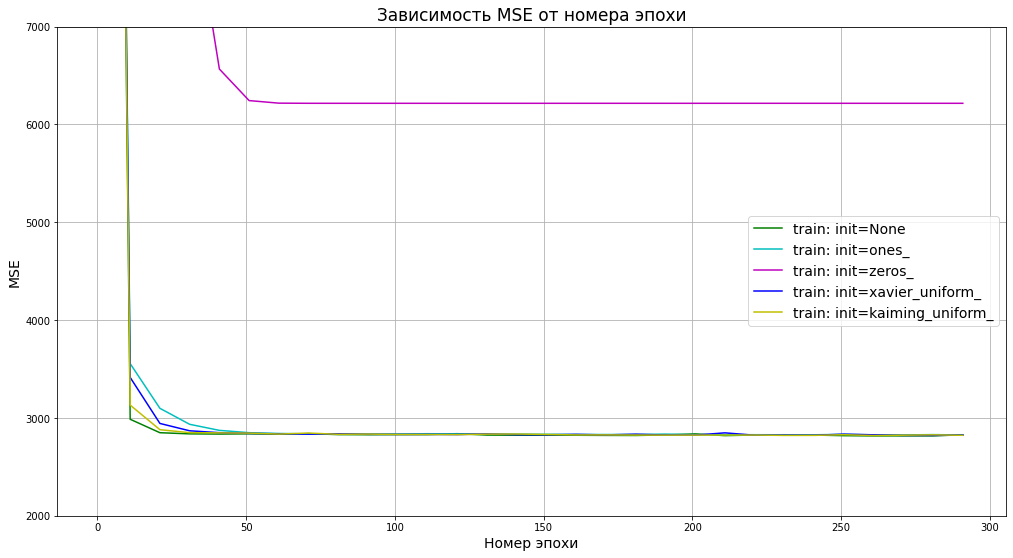

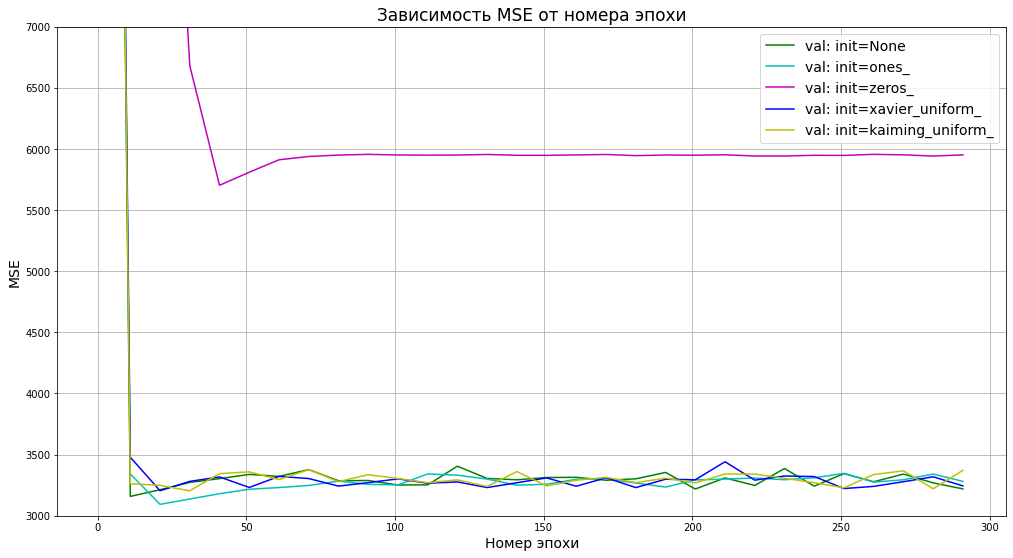

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_init_list, "train: init", parametrs=init_list, ylim=(2000, 7000))
print_graphic(num_epoch, val_result_init_list, "val: init", parametrs=init_list, ylim=(3000, 7000))

In [ ]:
# Лучший параметр
best_init = None

**Результат:** В данном случае даже инициализация одними единицами приводит к неплохим результатам, а вот инициализация нулями ожидаемо оказалась плохой. Все инициализации кроме нулевой показывают примерно одинаковый результат. В качестве лучшей стратегии инициализации оставим инициализацию по-умолчанию.

###### Активация:

In [ ]:
# Параметры
num_epoch = 500
lr = 0.01
gamma = 0.5
step_size = 300

train_result_act_list = []
val_result_act_list = []
for act in act_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=10,
                hidden_dim=best_width,
                output_dim=1,
                batch_norm=best_batch_norm,
                dropout=best_dropout,
                init=best_init,
                act=act)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer,
                                           train_dataloader, val_dataloader, device, scheduler)
    
    val_result_act_list.append(loss_list_val)
    train_result_act_list.append(loss_list_train)

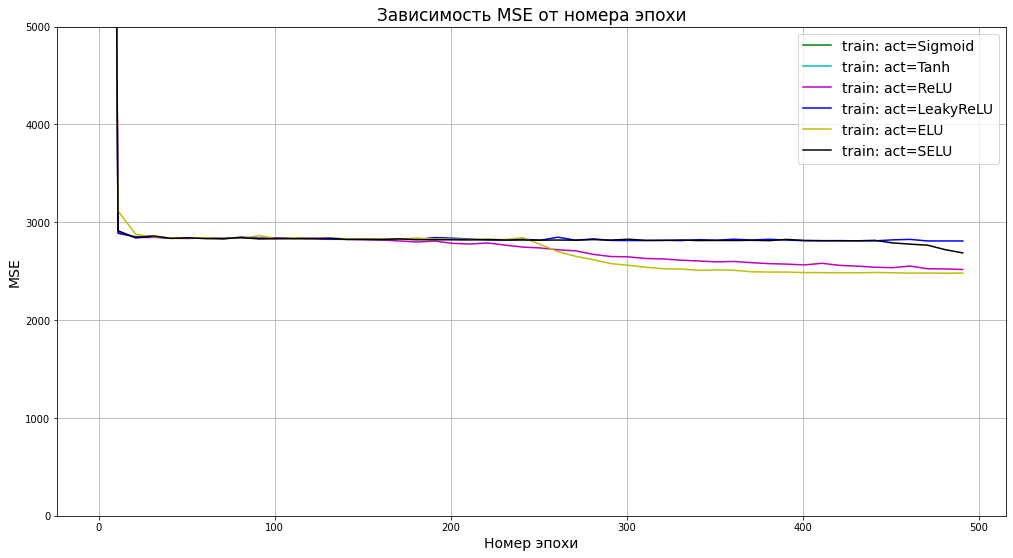

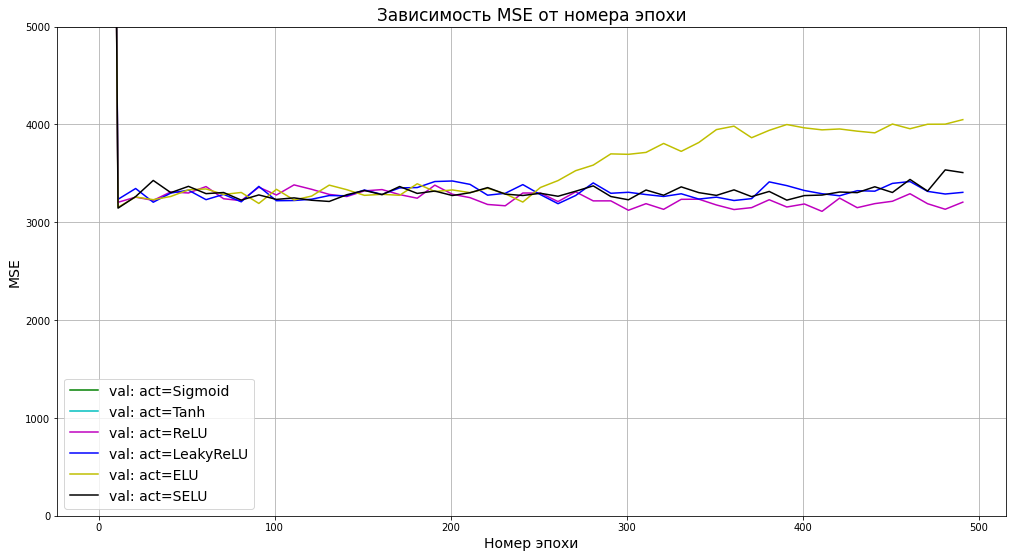

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_act_list, "train: act", parametrs=act_list, ylim=(0, 5000))
print_graphic(num_epoch, val_result_act_list, "val: act", parametrs=act_list, ylim=(0, 5000))

In [ ]:
# Лучший параметр
best_act = nn.ReLU

**Результат:** Использование сигмоиды и гиперболического тангенса не позволяет обучать сеть. Лучшие значения показывает **ReLU**.

###### Финальный тест:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.01
gamma = 0.5
step_size = 300

# Модель, функция потерь, ...
model = FFN(num_layers=best_depth,
            input_dim=10,
            hidden_dim=best_width,
            output_dim=1,
            batch_norm=best_batch_norm,
            dropout=best_dropout,
            init=best_init,
            act=best_act)
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

# Обучение
loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, 
                                       train_dataloader, val_dataloader, device, scheduler)

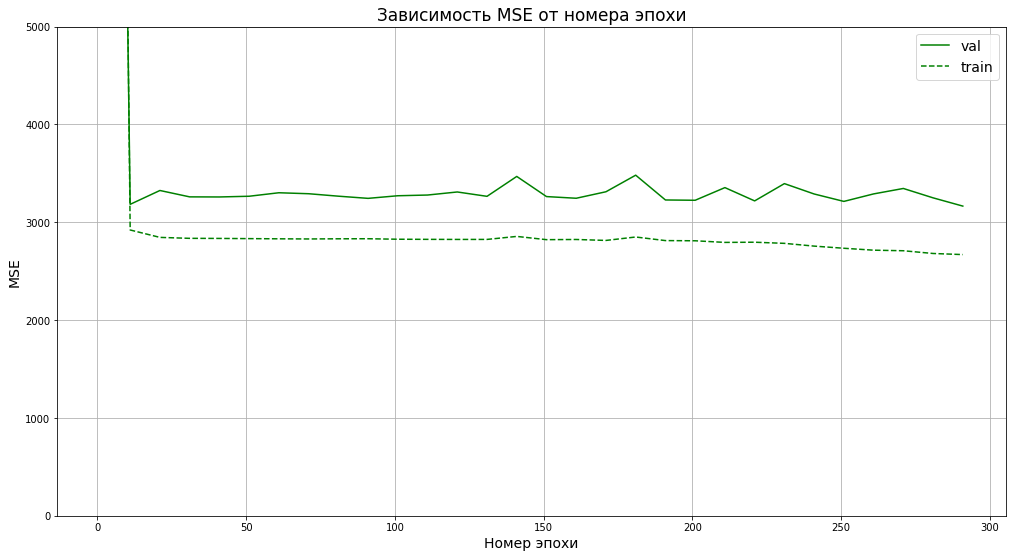

In [ ]:
# Вывод графика
print_graphic(num_epoch, [loss_list_val], "val",
              loss_list_2=[loss_list_train], label_2="train", ylim=(0, 5000))

In [ ]:
# Итоговое качество
print(f"MSE на тесте: {val(None, model, criterion, test_dataloader, device):.4f}")
print(f"MSE на валидации: {val(None, model, criterion, val_dataloader, device):.4f}")
print(f"MSE на трейне: {val(None, model, criterion, train_dataloader, device):.4f}")

MSE на тесте: 2718.7594
MSE на валидации: 3165.1524
MSE на трейне: 2669.5766


**Вывод:** Улучшение по сравнению с первоначальным измерением есть, но оно небольшое. Изначальные значения были близки к оптимальным.

##### **Wine recognition dataset (classification)**

In [ ]:
# Параметры
batch_size = 8
weight_decay = 1e-5


depth_list = [1, 2, 3, 4, 5, 7] # 6
width_list = [2, 3, 4, 5, 6, 7, 10, 15] # 8
batch_norm_list = [False, True] # 2
dropout_list = [0, 0.25, 0.5, 0.75] # 4
init_list = [None, nn.init.ones_, nn.init.zeros_,
             nn.init.xavier_uniform_, nn.init.kaiming_uniform_] # 5
act_list = [nn.Sigmoid, nn.Tanh, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.SELU] # 6

In [ ]:
# Загрузка данных
train_dataloader, test_dataloader, val_dataloader = load_dataset("wine", batch_size)

X.shape: (178, 13), y.shape: (178,)
Train samples: 106
Test samples: 36
Val samples: 36


###### Тестовый запуск:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

# Модель, функция потерь, ...
model = FFN(num_layers=2,
            input_dim=13,
            hidden_dim=10,
            output_dim=3,
            batch_norm=False,
            dropout=0,
            init=None,
            act=nn.ReLU)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

# Обучение
loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                       val_dataloader, device, scheduler, clf_flag=True)

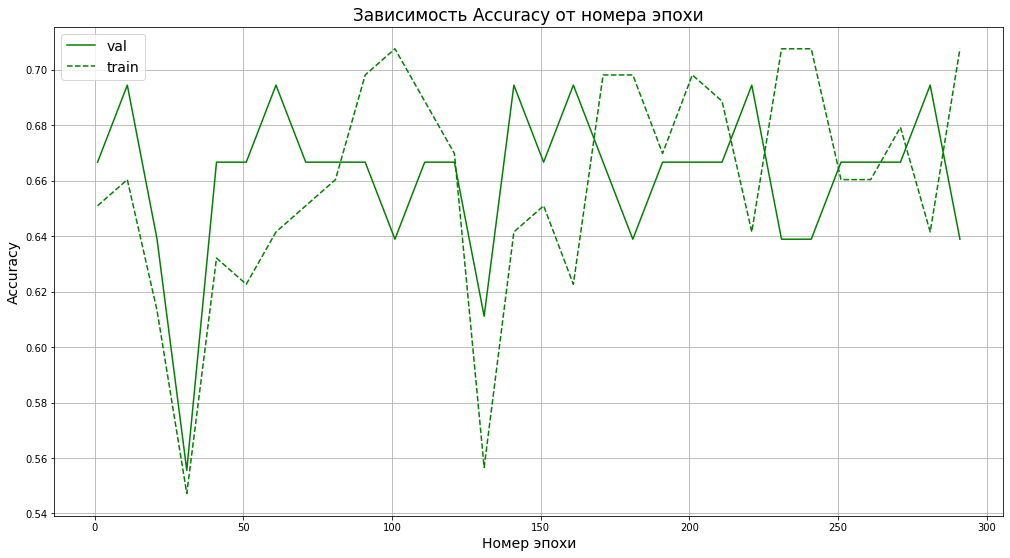

In [ ]:
# Вывод графика
print_graphic(num_epoch, [loss_list_val], "val",
              loss_list_2=[loss_list_train], label_2="train", ylim=None, clf_flag=True)

In [ ]:
# Итоговое качество
print(f"Accuracy на тесте: {val(None, model, criterion, test_dataloader, device, clf_flag=True):.4f}")
print(f"Accuracy на валидации: {val(None, model, criterion, val_dataloader, device, clf_flag=True):.4f}")
print(f"Accuracy на трейне: {val(None, model, criterion, train_dataloader, device, clf_flag=True):.4f}")

Accuracy на тесте: 0.6667
Accuracy на валидации: 0.6389
Accuracy на трейне: 0.7075


###### Ширина:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_width_list = []
val_result_width_list = []
for width in width_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=2,
                input_dim=13,
                hidden_dim=width,
                output_dim=3,
                batch_norm=False,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_width_list.append(loss_list_val)
    train_result_width_list.append(loss_list_train)

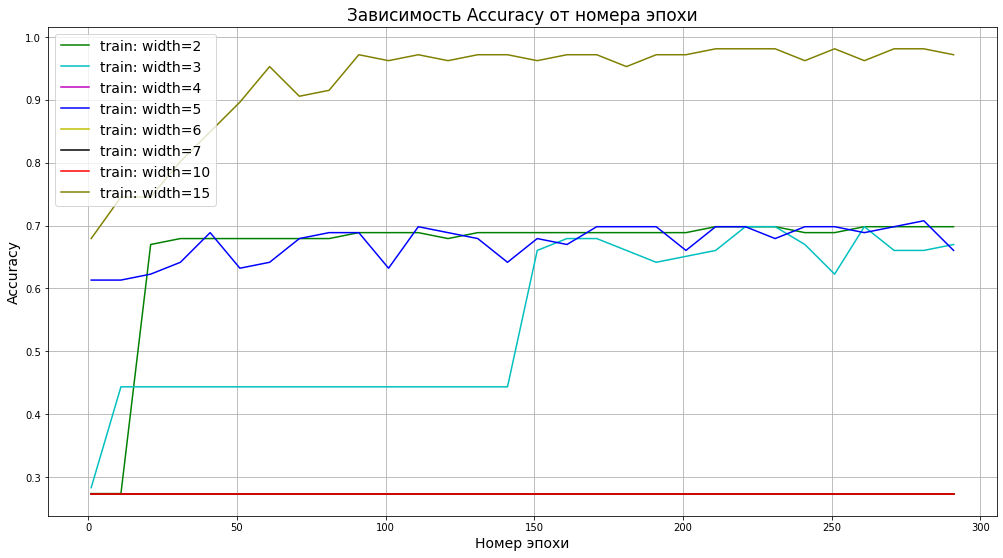

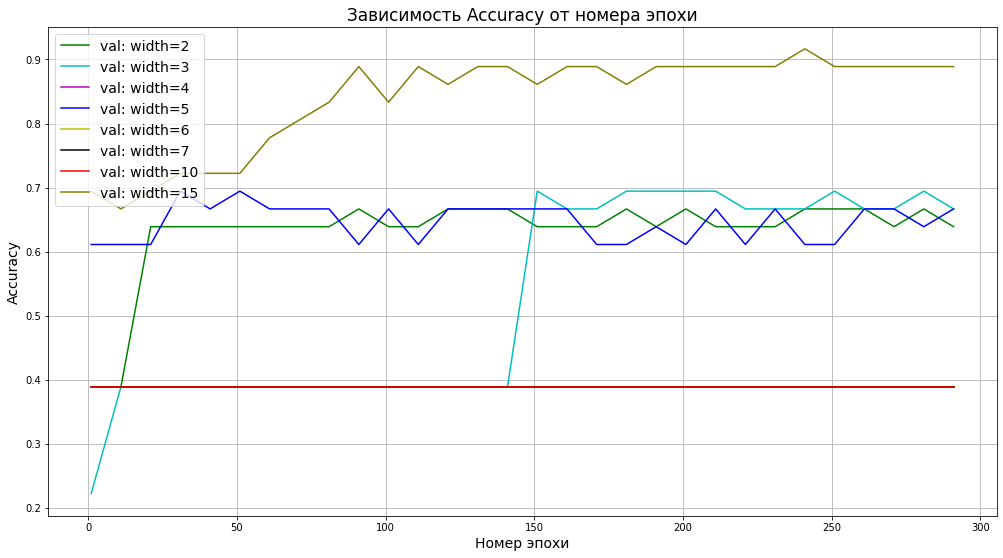

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_width_list, "train: width", parametrs=width_list, clf_flag=True)
print_graphic(num_epoch, val_result_width_list, "val: width", parametrs=width_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_width = 10

**Результат:** Лучшим значением выбрана ширина, равная $10$.

###### Глубина:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_depth_list = []
val_result_depth_list = []
for depth in depth_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=depth,
                input_dim=13,
                hidden_dim=best_width,
                output_dim=3,
                batch_norm=False,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_depth_list.append(loss_list_val)
    train_result_depth_list.append(loss_list_train)

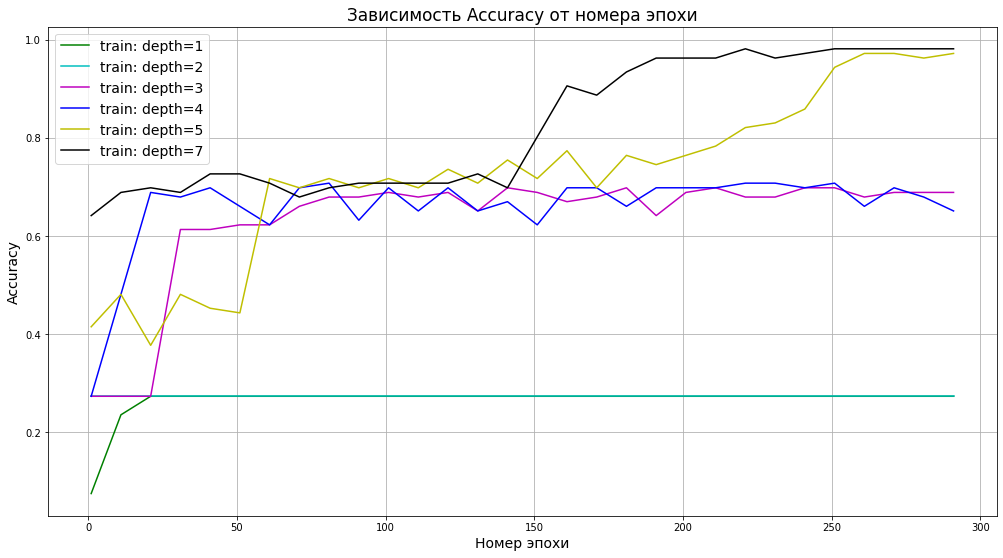

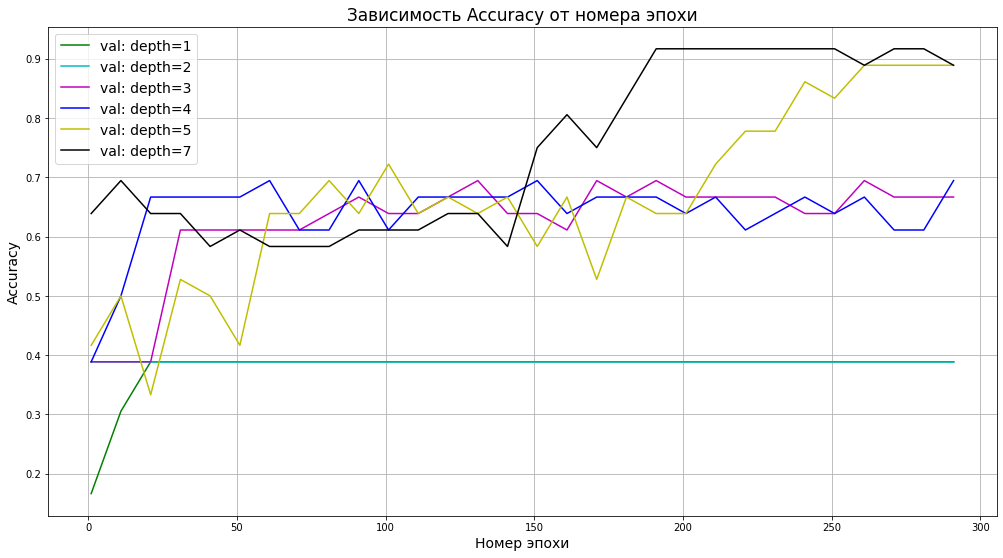

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_depth_list, "train: depth", parametrs=depth_list, clf_flag=True)
print_graphic(num_epoch, val_result_depth_list, "val: depth", parametrs=depth_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_depth = 7

**Результат:** Графики получились неоднозначными. Лучшее значение глубины выбрано равным $7$.

###### Batch Normalization:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_batch_norm_list = []
val_result_batch_norm_list = []
for batch_norm in batch_norm_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=13,
                hidden_dim=best_width,
                output_dim=3,
                batch_norm=batch_norm,
                dropout=0,
                init=None,
                act=nn.ReLU)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_batch_norm_list.append(loss_list_val)
    train_result_batch_norm_list.append(loss_list_train)

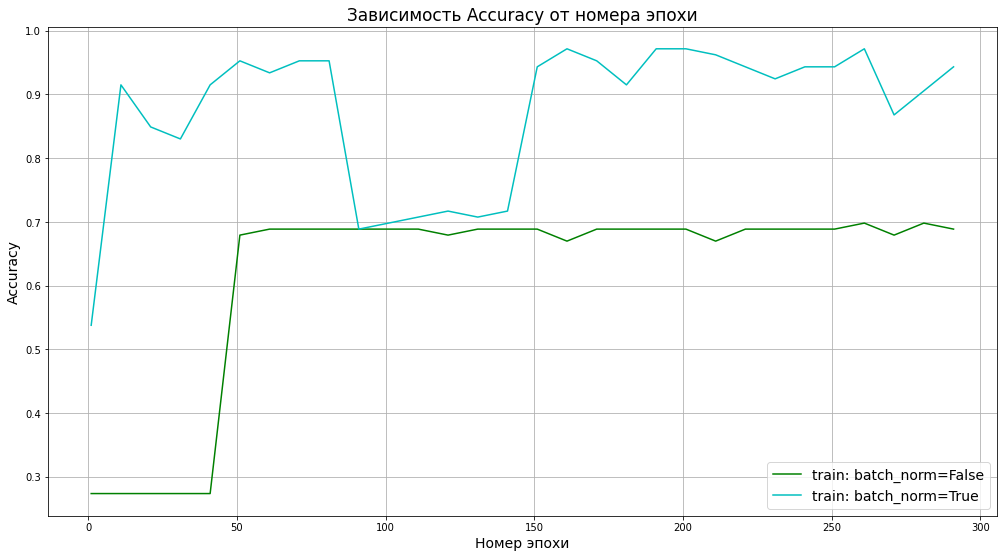

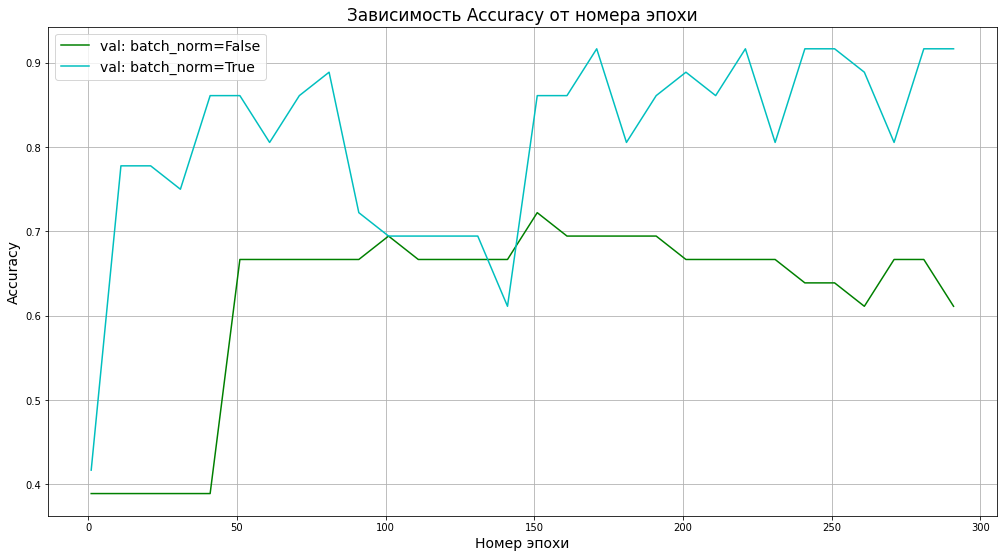

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_batch_norm_list, "train: batch_norm", parametrs=batch_norm_list, clf_flag=True)
print_graphic(num_epoch, val_result_batch_norm_list, "val: batch_norm", parametrs=batch_norm_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_batch_norm = True

**Результат:** Использование батч-нормализации позитивно сказывается на точности. Будем её использовать.

###### Dropout:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_dropout_list = []
val_result_dropout_list = []
for dropout in dropout_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=13,
                hidden_dim=best_width,
                output_dim=3,
                batch_norm=best_batch_norm,
                dropout=dropout,
                init=None,
                act=nn.ReLU)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_dropout_list.append(loss_list_val)
    train_result_dropout_list.append(loss_list_train)

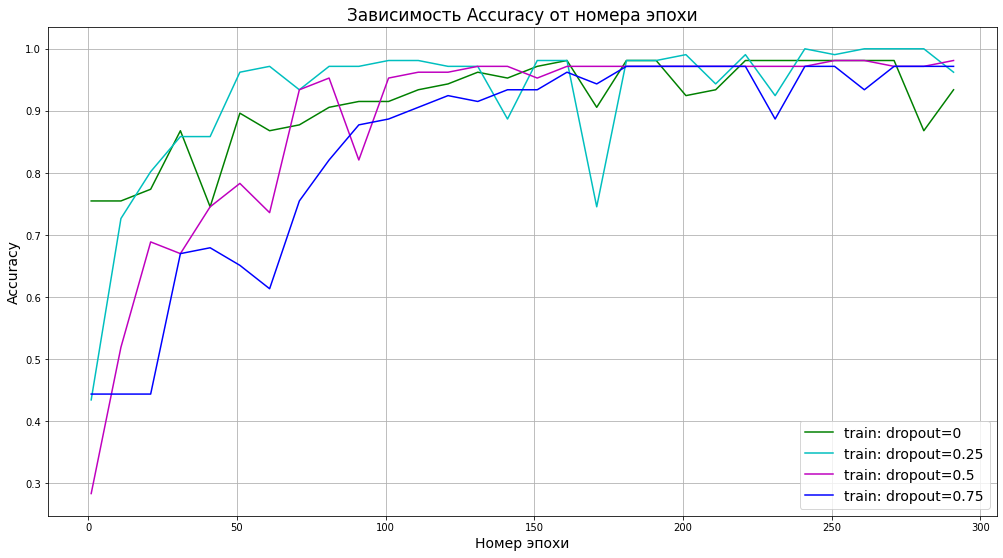

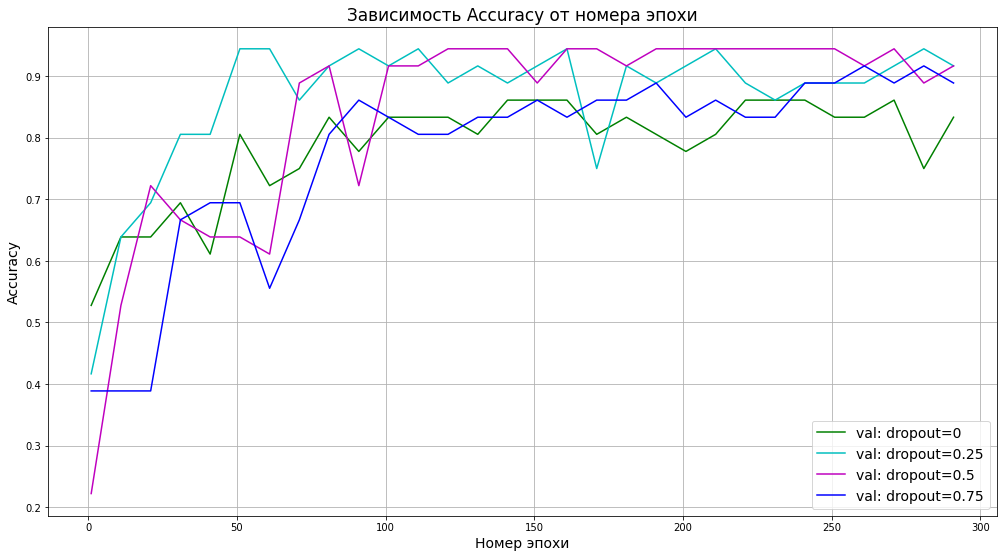

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_dropout_list, "train: dropout", parametrs=dropout_list, clf_flag=True)
print_graphic(num_epoch, val_result_dropout_list, "val: dropout", parametrs=dropout_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_dropout = 0.25

**Результат:** Присутствие dropout не улучшает качество. В нашем случае сеть не переобучается, поэтому нет необходимости использовать dropout, который является регуляризатором сетей.

###### Init:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_init_list = []
val_result_init_list = []
for init in init_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=13,
                hidden_dim=best_width,
                output_dim=3,
                batch_norm=best_batch_norm,
                dropout=best_dropout,
                init=init,
                act=nn.ReLU)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_init_list.append(loss_list_val)
    train_result_init_list.append(loss_list_train)

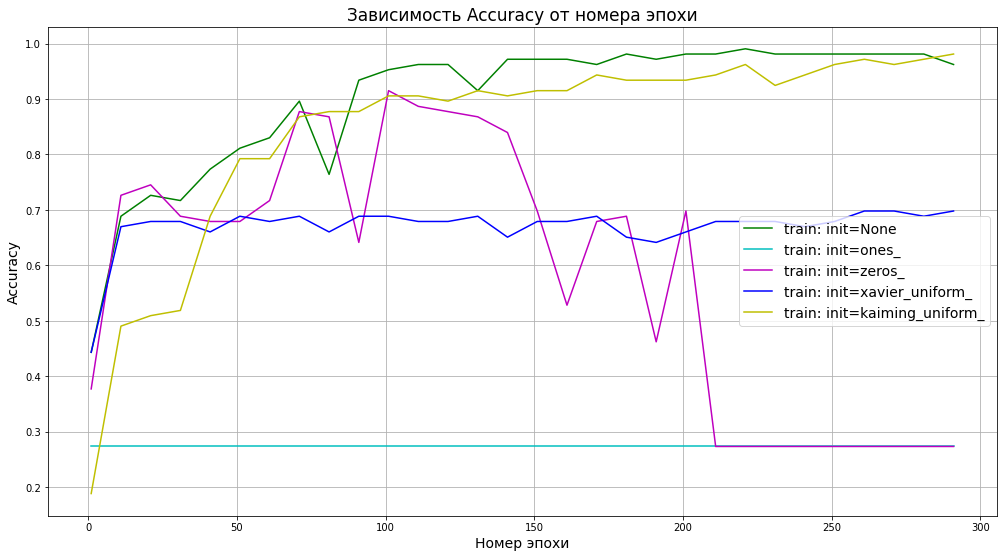

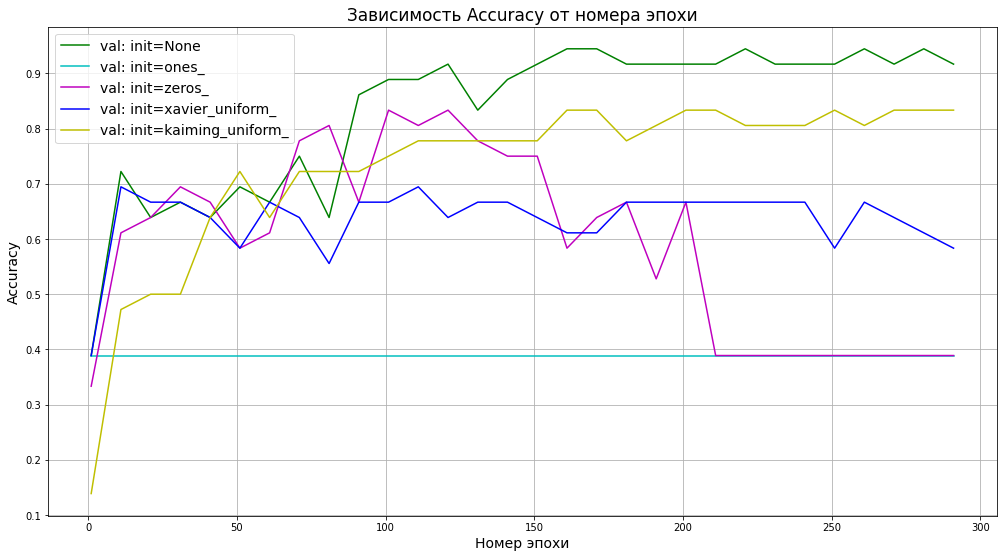

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_init_list, "train: init", parametrs=init_list, clf_flag=True)
print_graphic(num_epoch, val_result_init_list, "val: init", parametrs=init_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_init = None

**Результат:** В данном случае лучшим методом инициализации оказалась инициализация по умолчанию.

###### Активация:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

train_result_act_list = []
val_result_act_list = []
for act in act_list:
    # Модель, функция потерь, ...
    model = FFN(num_layers=best_depth,
                input_dim=13,
                hidden_dim=best_width,
                output_dim=3,
                batch_norm=best_batch_norm,
                dropout=best_dropout,
                init=best_init,
                act=act)
    criterion = nn.CrossEntropyLoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

    # Обучение
    loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                        val_dataloader, device, scheduler, clf_flag=True)
    
    val_result_act_list.append(loss_list_val)
    train_result_act_list.append(loss_list_train)

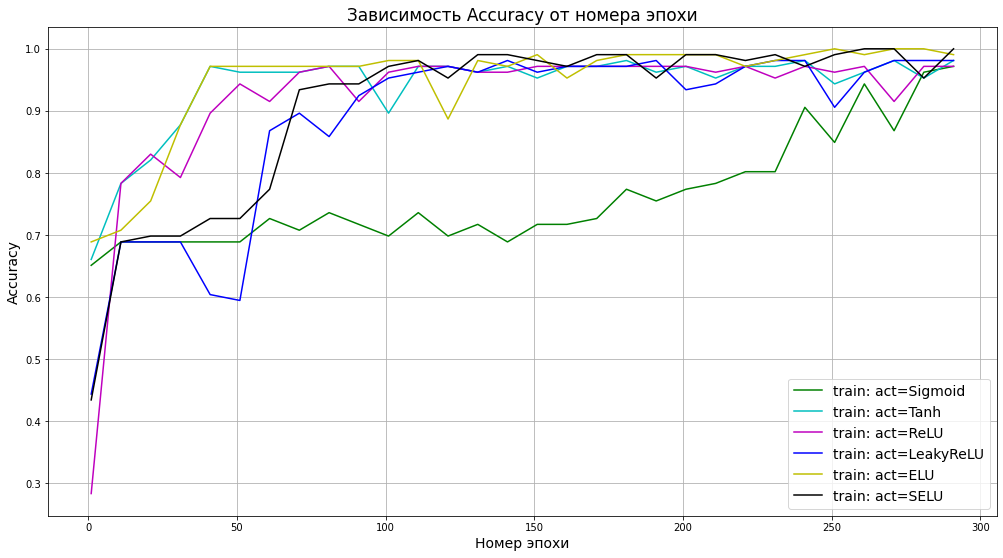

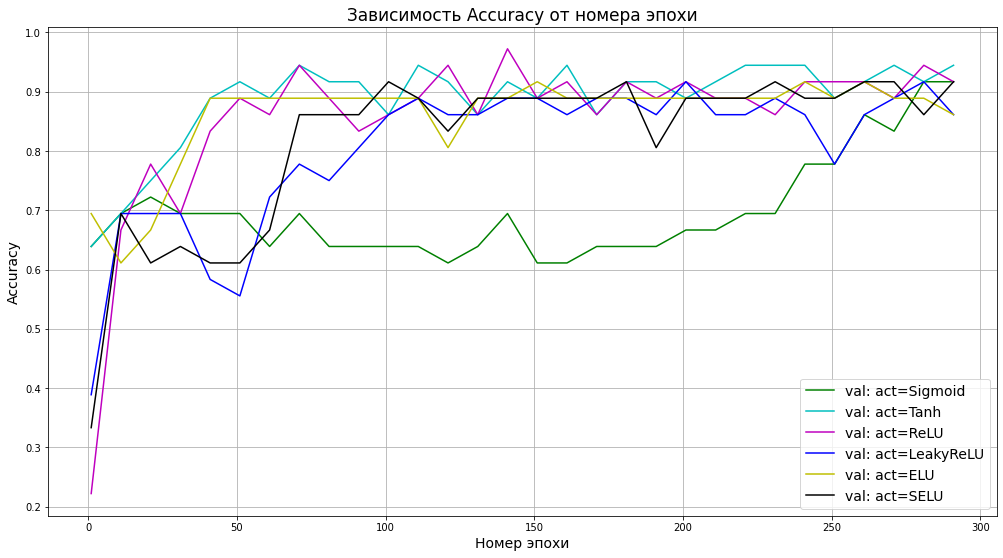

In [ ]:
# Вывод графика
print_graphic(num_epoch, train_result_act_list, "train: act", parametrs=act_list, clf_flag=True)
print_graphic(num_epoch, val_result_act_list, "val: act", parametrs=act_list, clf_flag=True)

In [ ]:
# Лучший параметр
best_act = nn.Tanh

**Результат:** В качестве лучшей функции активации выберем **Tanh**.

###### Финальный тест:

In [ ]:
# Параметры
num_epoch = 300
lr = 0.001
gamma = 0.5
step_size = 300

# Модель, функция потерь, ...
model = FFN(num_layers=best_depth,
            input_dim=13,
            hidden_dim=best_width,
            output_dim=3,
            batch_norm=best_batch_norm,
            dropout=best_dropout,
            init=best_init,
            act=best_act)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)

# Обучение
loss_list_val, loss_list_train = train(model, num_epoch, criterion, optimizer, train_dataloader,
                                       val_dataloader, device, scheduler, clf_flag=True)

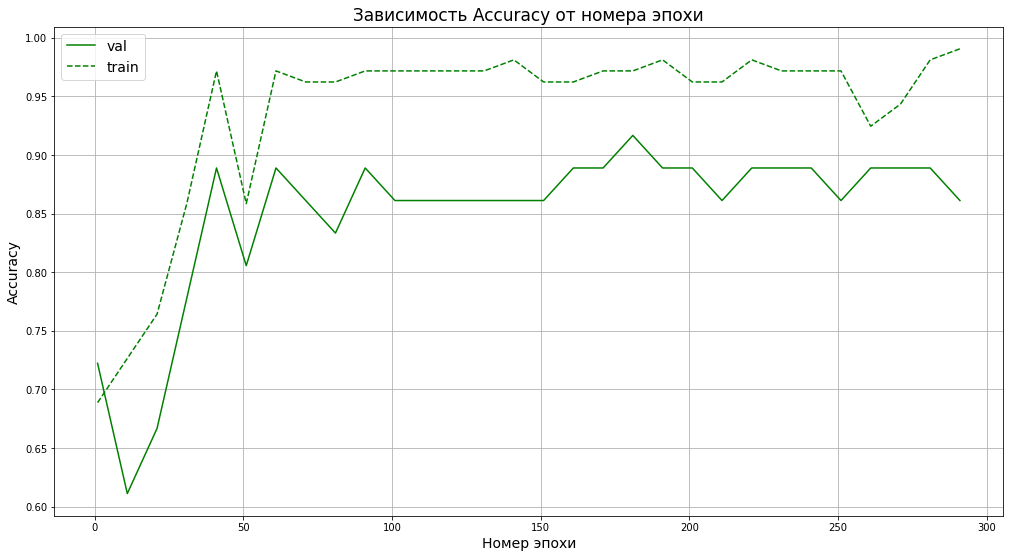

In [ ]:
# Вывод графика
print_graphic(num_epoch, [loss_list_val], "val",
              loss_list_2=[loss_list_train], label_2="train", clf_flag=True)

In [ ]:
# Итоговое качество
print(f"Accuracy на тесте: {val(None, model, criterion, test_dataloader, device, clf_flag=True):.4f}")
print(f"Accuracy на валидации: {val(None, model, criterion, val_dataloader, device, clf_flag=True):.4f}")
print(f"Accuracy на трейне: {val(None, model, criterion, train_dataloader, device, clf_flag=True):.4f}")

Accuracy на тесте: 0.9167
Accuracy на валидации: 0.8611
Accuracy на трейне: 0.9906


**Комментарии:** Качество улучшилось по сравнению с первоначальным замером.